## FIRST PART

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [4]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Math
import emcee
import corner
import random

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
random.seed(8)

In [6]:
file = np.load('transient.npy')

In [7]:
time = np.zeros(len(file))
flux = np.zeros(len(file))
err_flux = np.zeros(len(file))

for i in range(len(file)):
   time[i] = file[i][0]
   flux[i] = file[i][1]
   err_flux[i] = file[i][2]


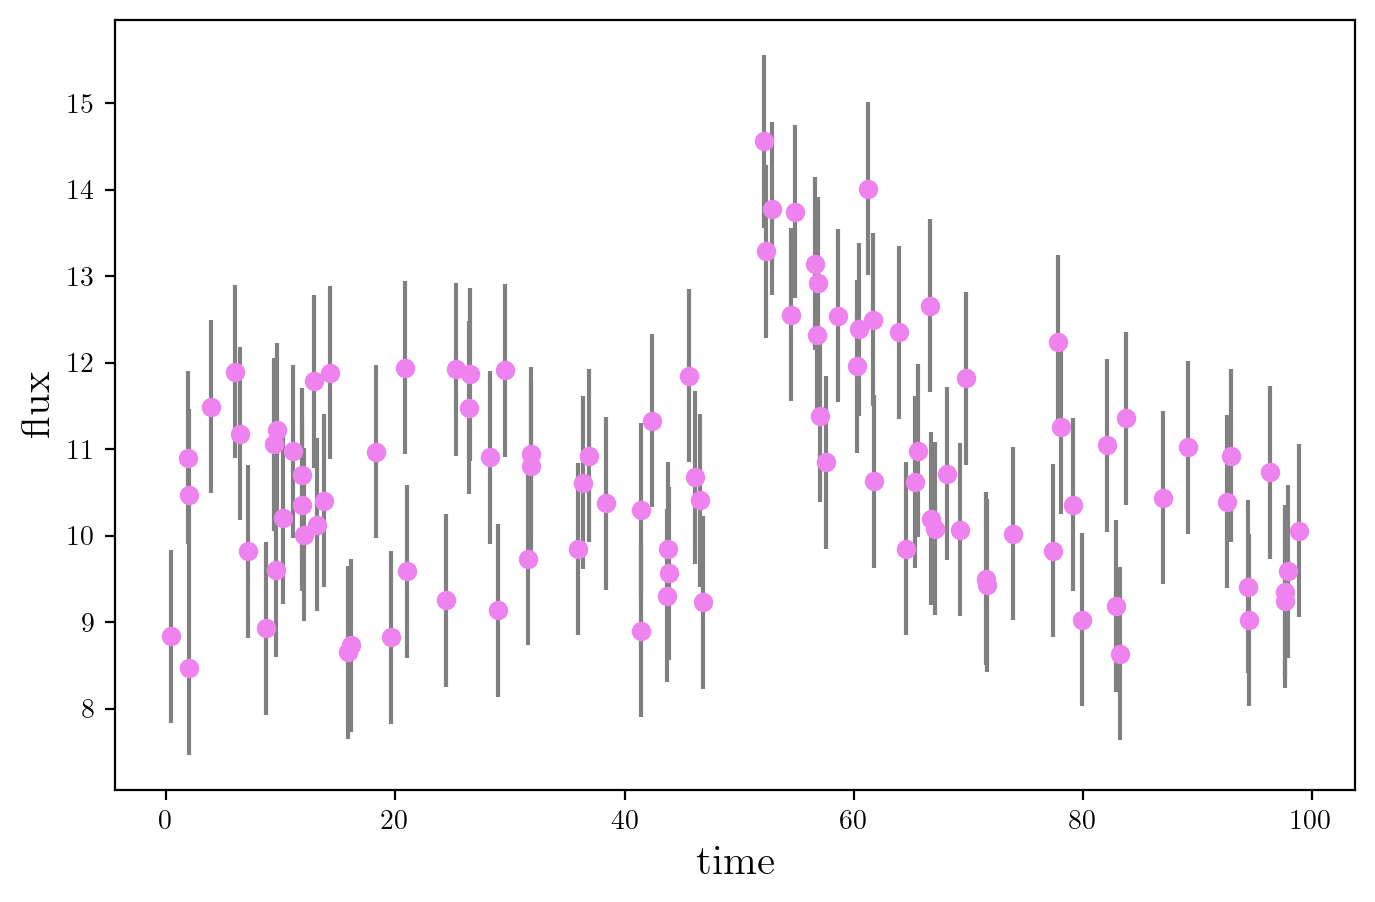

In [8]:
fig = plt.figure(figsize=(8, 5))
plt.errorbar(time, flux, yerr=err_flux, color='violet', ecolor='grey',fmt='o')
plt.xlabel('time',fontsize=15)
plt.ylabel('flux',fontsize=15)
plt.show()


## SECOND PART

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 


In [9]:
def burst(t, t0, b, A, alpha):
    return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))

In [10]:
#written like this bc I need it after
def likelihood(params, t, y_obs, sigma):
    
    t0, b, A, alpha = params 
    
    y_pred = burst(t, t0, b, A, alpha)
    residuals = y_obs - y_pred

    L = np.exp(-0.5 * np.sum((residuals / sigma) ** 2 + np.log(2 * np.pi * sigma**2)))
    
    return L

def neg_log_likelihood(params, t, y_obs, sigma):
    return -np.log(likelihood(params, t, y_obs, sigma))

In [14]:
sigma = err_flux[0]

initial_params = [50.0, 10.0, 2.0, 0.5]

result = minimize(neg_log_likelihood, initial_params, args=(time, flux, sigma)) #you can also choose opt method
best_params = result.x #the minimum founded (.fun x funct in min)

t0, b, A, alpha = best_params
print(best_params)

[52.15852308 10.51041119  3.7155308   0.12732854]


/tmp/ipykernel_294702/1220629389.py:14: RuntimeWarning: divide by zero encountered in log
  return -np.log(likelihood(params, t, y_obs, sigma))
/home/ludovicarbone/astrostat_env/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_294702/1220629389.py:14: RuntimeWarning: divide by zero encountered in log
  return -np.log(likelihood(params, t, y_obs, sigma))


Best-fit parameters:

$t_0$ 52.17714962 

$b$  10.39835133

$A$    3.70567886

$\alpha$   0.12670954

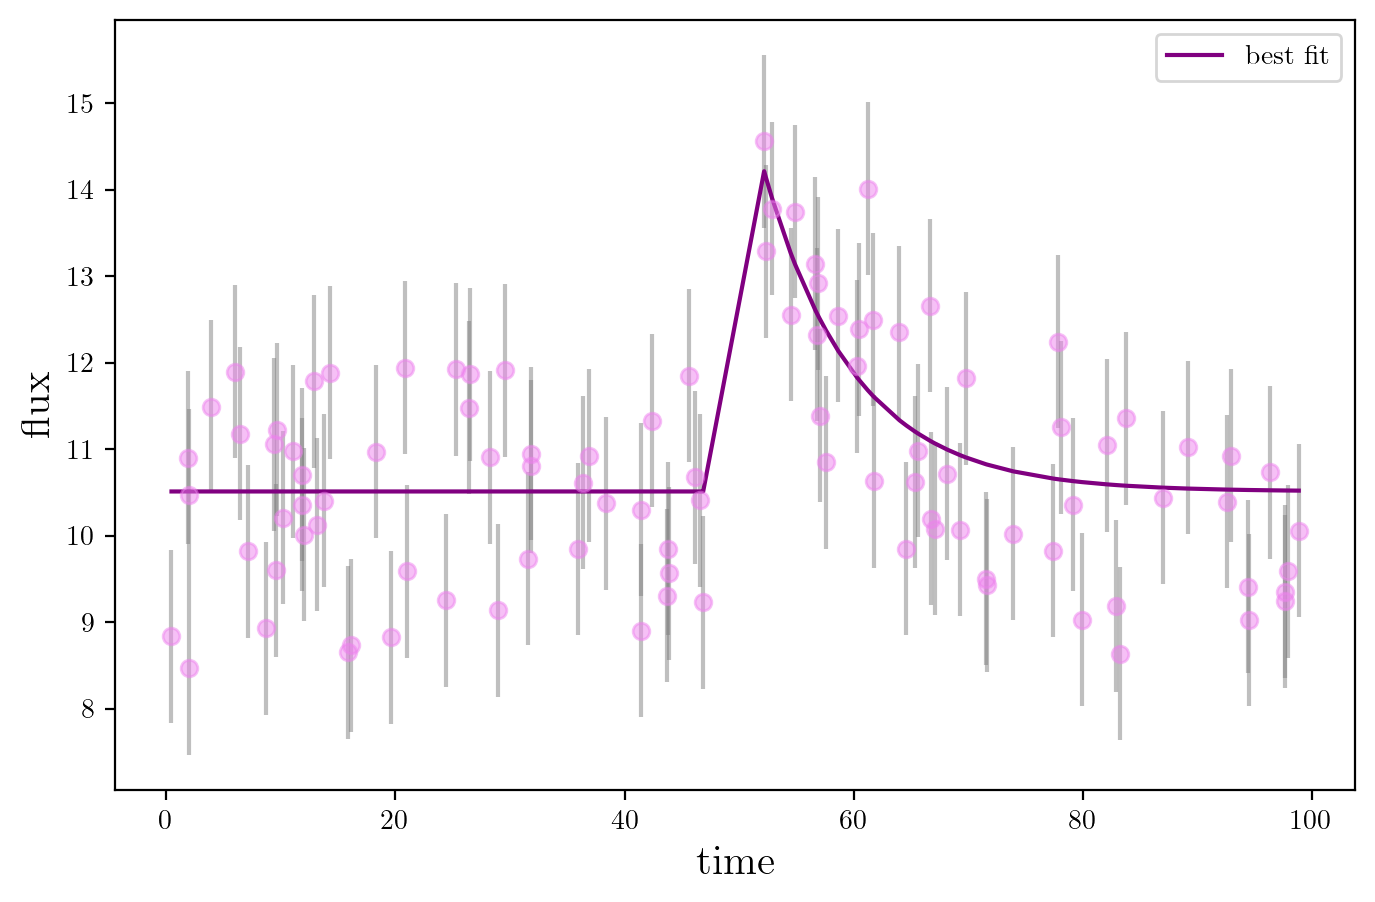

In [15]:
fig = plt.figure(figsize=(8, 5))
plt.errorbar(time, flux, yerr=err_flux, ecolor='grey', color='violet', fmt='o', alpha=0.5)
plt.plot(time, burst(time, t0, b, A, alpha), color='purple', label='best fit')

plt.xlabel('time',fontsize=15)
plt.ylabel('flux',fontsize=15)
plt.legend()
plt.show()

## MCMC

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).


In [16]:
def flat_prior (par, min, max):
    return 1 / (max - min)

In [17]:
def logflat_prior(par, min, max):
    if np.log(par) < min or np.log(par) > max or par <= 0:
        return 0
    return 1 / par

In [18]:
def log_posterior(params, t, y_obs, sigma, params_prior):
    t0, b, A, alpha = params

    prior_t0 = flat_prior(t0, params_prior[0][0], params_prior[0][1])
    prior_b = flat_prior(b, params_prior[1][0], params_prior[1][1])
    prior_A = flat_prior(A, params_prior[2][0], params_prior[2][1])
    prior_alpha = logflat_prior(alpha, params_prior[3][0], params_prior[3][1])

    if prior_t0 == 0 or prior_b == 0 or prior_A == 0 or prior_alpha == 0:
        return -np.inf  
    
    # Likelihood
    L = likelihood(params, t, y_obs, sigma)
    
    if L == 0 or np.isnan(L):
        return -np.inf  # Se la likelihood è zero o non valida, restituisci -inf
    
    logL = np.log(likelihood(params, t, y_obs, sigma))
    log_prior = np.log(prior_t0 * prior_b * prior_A * prior_alpha)
    
    return logL + log_prior

In [19]:
params_prior = [
    (0, 100),   # t0
    (0, 50),    # b
    (0, 50),    # A
    (-5, 5)   # alpha (log-flat prior, quindi valori positivi)
]

In [20]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 500000  # number of MCMC steps for each walker

initial_params = np.array([50.0, 10.0, 3.0, 0.5])

In [24]:
pos = [initial_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] #add lil pert
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[time, flux, sigma, params_prior])
_ = sampler.run_mcmc(pos, nsteps, progress=True) #now sampler has chain for every walker

  0%|                                                                                        | 0/500000 [00:00<?, ?it/s]/tmp/ipykernel_294702/266245947.py:2: RuntimeWarning: invalid value encountered in log
  if np.log(par) < min or np.log(par) > max or par <= 0:
100%|█████████████████████████████████████████████████████████████████████████| 500000/500000 [08:06<00:00, 1028.36it/s]


In [25]:
#exclude first burn of the chain
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim) #[n_walkers * (n_steps - burn), ndim]
emcee_trace.flatten()  #1D

tau = sampler.get_autocorr_time() #high tau high autocorr, 1 time for every far
print(f"Autocorrelation times : {tau}")

thin = int(np.max(tau) + 1) #use the max autocorr time to thin
print(f"Thinning factor: {thin}")

#samples after thin and burn
emcee_trace_thin = sampler.get_chain(discard=burn, thin=thin, flat=True) 
print(f"Number of samples after thinning: {len(emcee_trace_thin)}")

Autocorrelation times : [92.01905962 68.97375528 93.13300244 75.60830637]
Thinning factor: 94
Number of samples after thinning: 52120


In [47]:
np.save('emcee_trace.npy', emcee_trace)  
np.save('emcee_trace_thin.npy', emcee_trace_thin) 

In [15]:
emcee_trace = np.load('emcee_trace.npy')
emcee_trace_thin = np.load('emcee_trace_thin.npy')

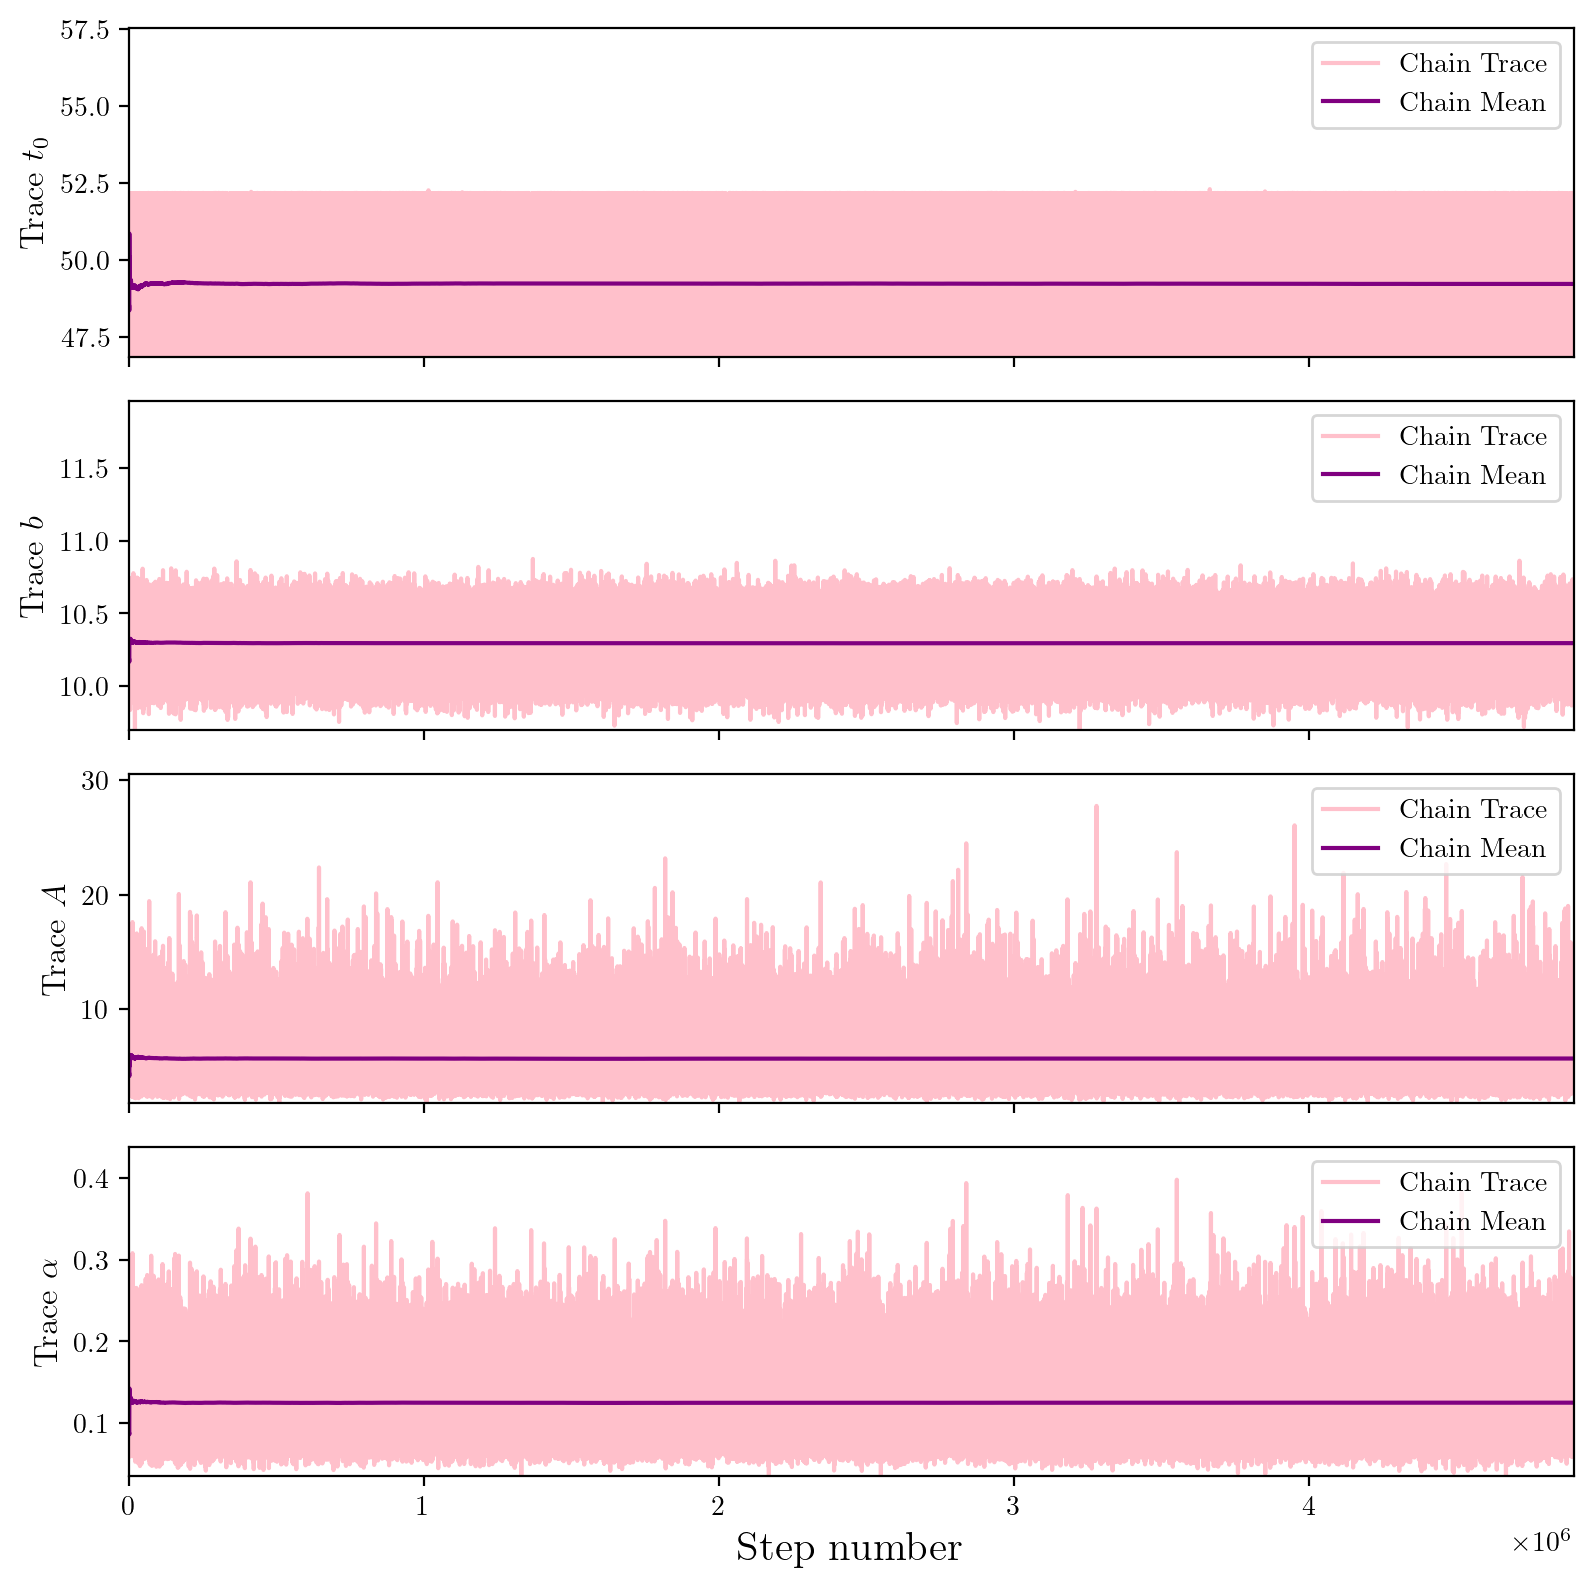

In [16]:
M = emcee_trace.shape[0]  

fig, axes = plt.subplots(ndim, 1, figsize=(8, 2 * ndim), sharex=True)

xgrid = np.linspace(1, M, M)

#cumulative mean
meanC = np.array([np.cumsum(emcee_trace[:, i]) / (np.arange(M) + 1) for i in range(ndim)])

# traces
labels = [r'$t_0$', r'$b$', r'$A$', r'$\alpha$']
for i in range(ndim):
    axes[i].plot(xgrid, emcee_trace[:, i], color='pink', label='Chain Trace')
    axes[i].plot(xgrid, meanC[i], color='purple', label='Chain Mean')

    axes[i].set_ylabel(f'Trace {labels[i]}', fontsize=12)
    axes[i].axis([0, M, np.min(emcee_trace[:, i]), 1.1 * np.max(emcee_trace[:, i])])
    axes[i].legend(fontsize=10, loc='upper right')

plt.xlabel('Step number', fontsize=15)

plt.tight_layout()
plt.show()

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 


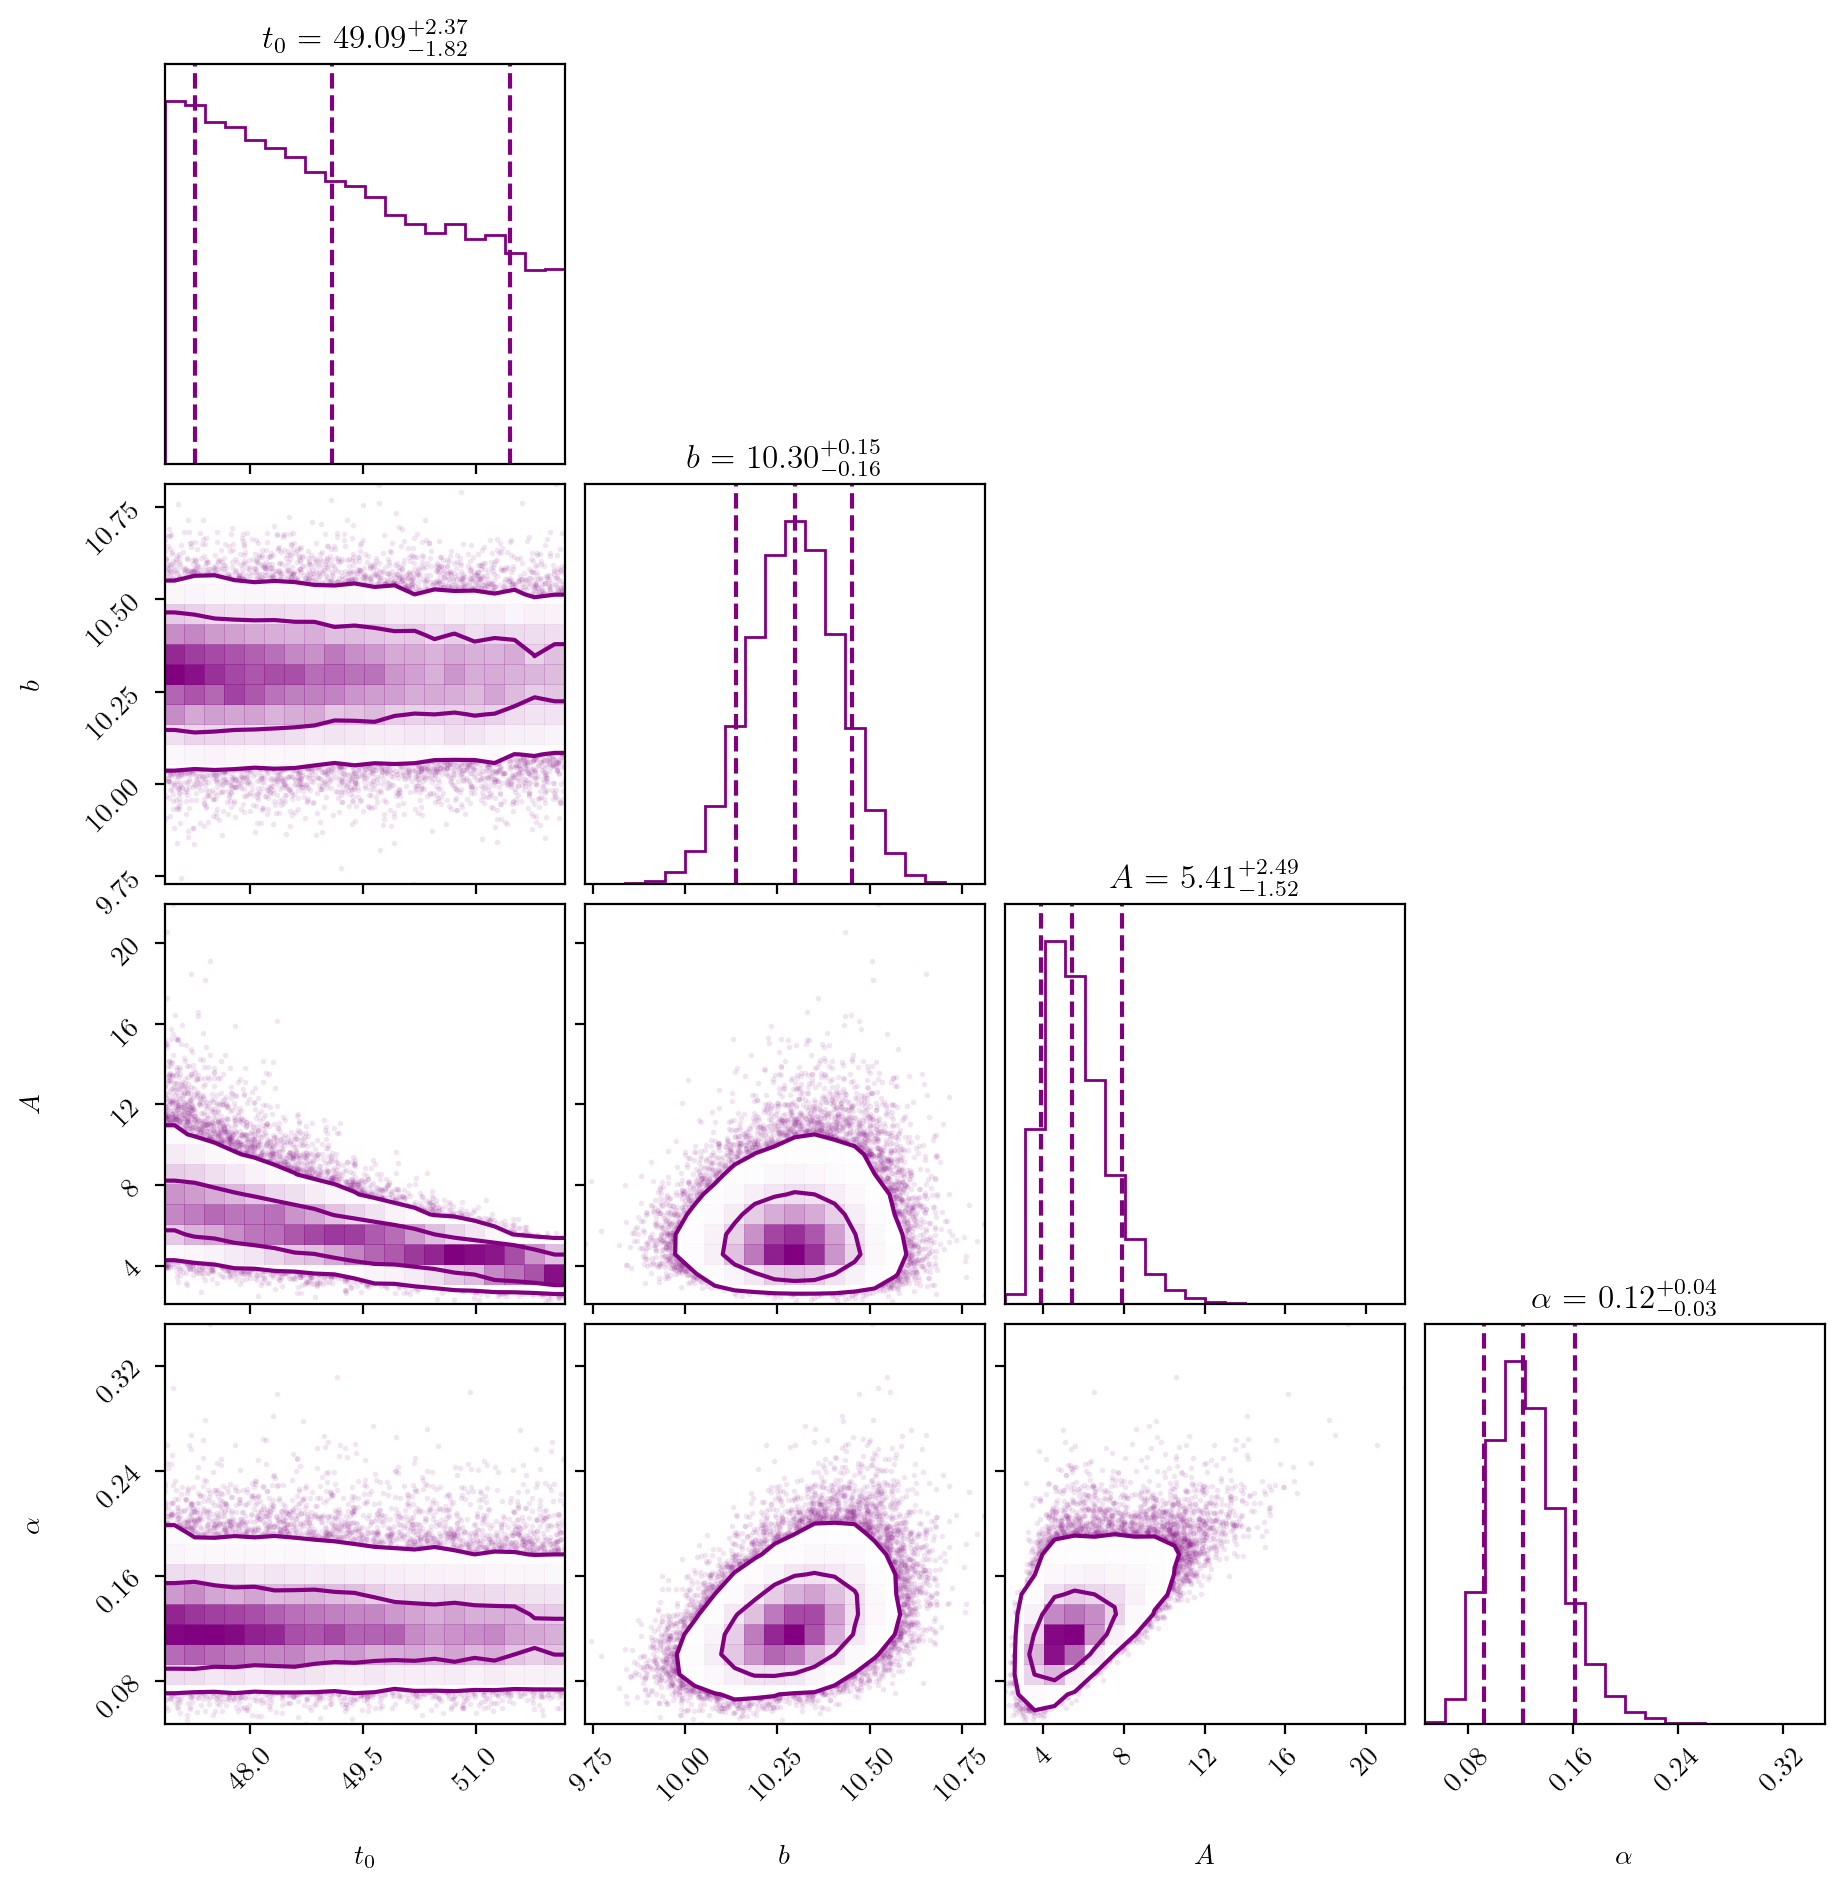

In [17]:
labels = [r'$t_0$', r'$b$', r'$A$', r'$\alpha$']

# Corner plots w/ (68% e 95%) and quantiles
fig = corner.corner(
    emcee_trace_thin,                      
    labels=labels,                        
    quantiles=[0.10, 0.5, 0.90],           
    show_titles=True,                      
    title_fmt=".2f",                       
    levels=(0.68, 0.95),                  
    plot_density=True,                                       
    color='purple'                           
)

fig.show()

In [24]:
quantiles = np.percentile(emcee_trace_thin, [10, 50, 90], axis=0)
print('Medians\n')
for i, label in enumerate(labels):
    median = quantiles[1, i]
    q10 = quantiles[0, i]
    q90 = quantiles[2, i]
    print(f"{label}: {median:.2f} ± [{median - q10:.2f}, {q90 - median:.2f}]")

Medians

$t_0$: 49.09 ± [1.82, 2.37]
$b$: 10.30 ± [0.16, 0.15]
$A$: 5.41 ± [1.52, 2.49]
$\alpha$: 0.12 ± [0.03, 0.04]


6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

In [18]:
len(emcee_trace_thin)

52680

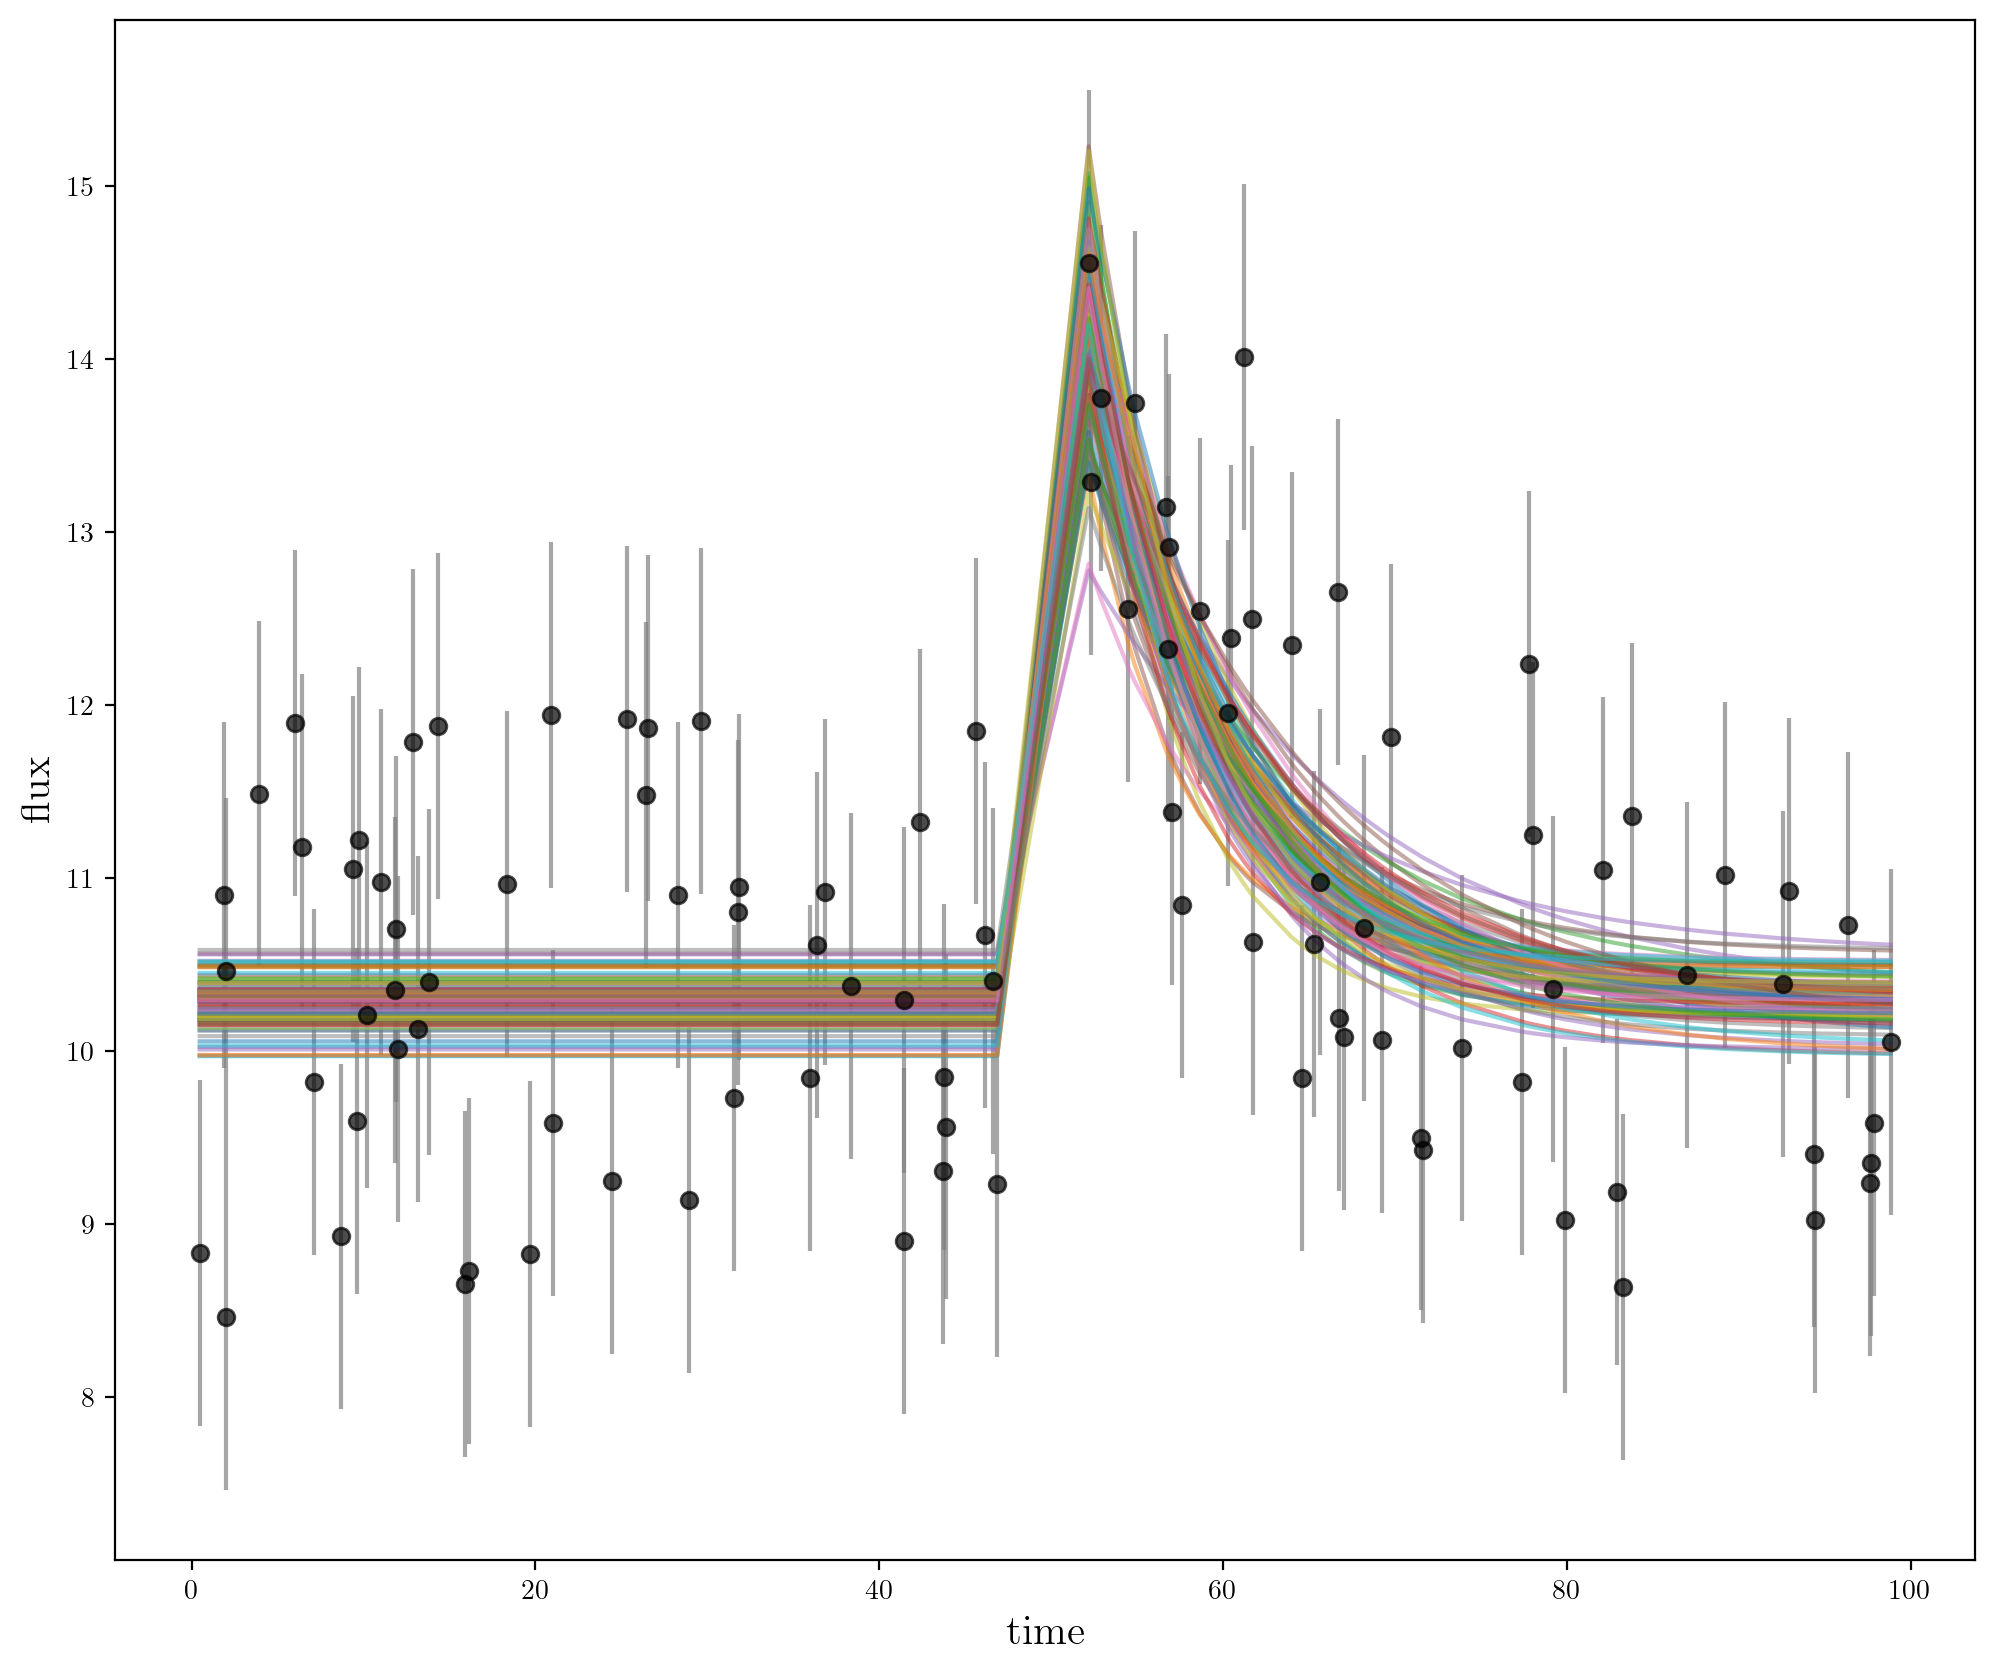

In [19]:
fig = plt.figure(figsize=(12, 10))
plt.errorbar(time, flux, yerr=err_flux, color='black', ecolor='grey',fmt='o', alpha=0.7)

samples = np.random.choice(np.arange(0, len(emcee_trace_thin)), size=100, replace=False)
for i in samples:
    t0, b, A, alpha = emcee_trace_thin[i]
    plt.plot(time, burst(time, t0, b, A, alpha), alpha=0.5)


plt.xlabel('time',fontsize=15)
plt.ylabel('flux',fontsize=15)
plt.show()

## NESTED SAMPLING

### Burst Model

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

In [26]:
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [27]:
#dimensionality of problem
ndim = 4

In [28]:
def norm_loglike(params): #nested sampling wants the like to take only par as argument
    N = len(flux)
    
    logL = np.log(likelihood(params, time, flux, sigma))
        
    lnorm = -0.5 * N * np.log(2 * np.pi * sigma**2)
    
    return logL + lnorm

In [29]:
def nest_flat_prior(u, min_val, max_val):
    # `u` between 0 e 1 transform in space par
    return min_val + u * (max_val - min_val)

def nest_logflat_prior(u, min_val, max_val):
    # `u` between 0 e 1 transform in log space par
    return np.exp(min_val + u * (max_val - min_val))

In [30]:
def prior_transform(u):
    t0 = nest_flat_prior(u[0], params_prior[0][0], params_prior[0][1])
    A  = nest_flat_prior(u[1], params_prior[1][0], params_prior[1][1])
    b  = nest_flat_prior(u[2], params_prior[2][0], params_prior[2][1])
    alpha = nest_logflat_prior(u[3], params_prior[3][0], params_prior[3][1])
    
    return [t0, A, b, alpha]

In [31]:
#increase the live points to try to avoid problems in campionamento 
sampler = dynesty.NestedSampler(norm_loglike, prior_transform, ndim) 
sampler.run_nested()
sresults = sampler.results

/tmp/ipykernel_2276/3617051522.py:5: RuntimeWarning: divide by zero encountered in log
  logL = np.log(likelihood(params, time, flux, sigma))
/tmp/ipykernel_2276/555155178.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
/tmp/ipykernel_2276/555155178.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
34it [00:00, 337.72it/s, bound: 0 | nc: 12 | ncall: 956 | eff(%):  3.556 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509]/tmp/ipykernel_2276/555155178.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
/tmp/ipykernel_2276/3617051522.py:5: RuntimeWarning: divide by zero encountered in log
  logL = np.log(likelihood(params, time, flux, sigma))
/tmp/ipykernel_2276/555155178.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + 

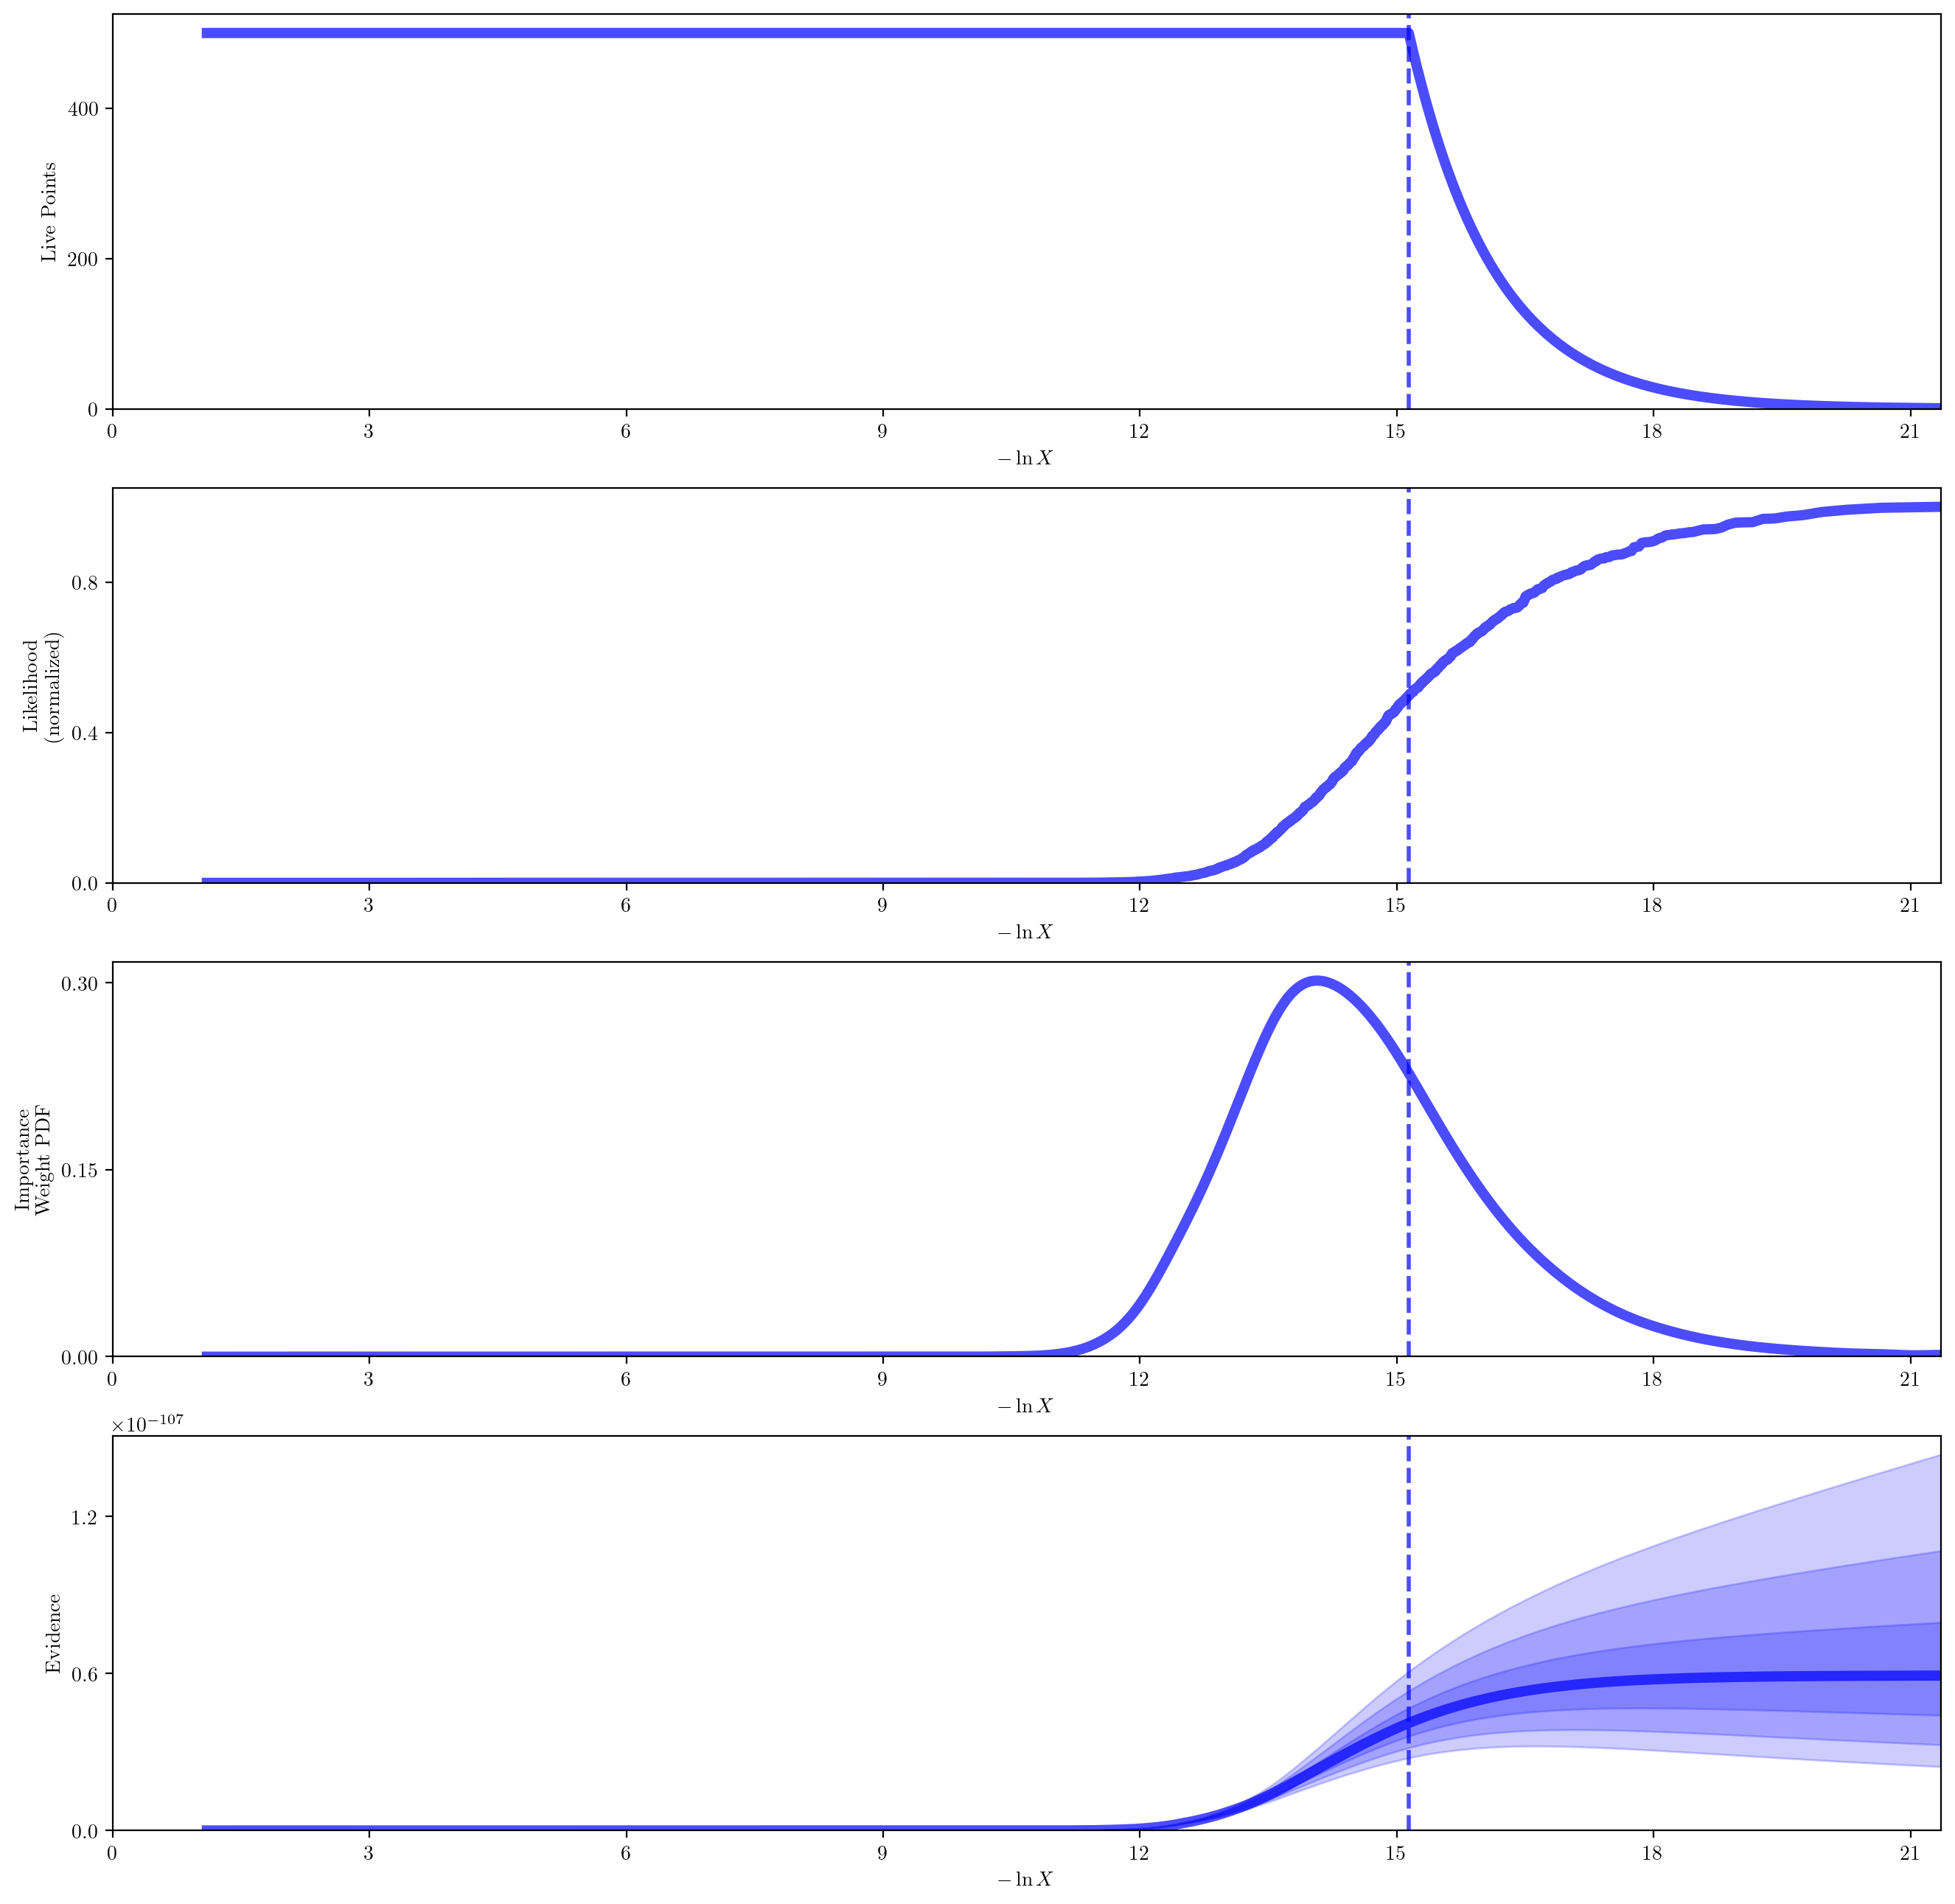

In [32]:
rfig, raxes = dyplot.runplot(sresults)

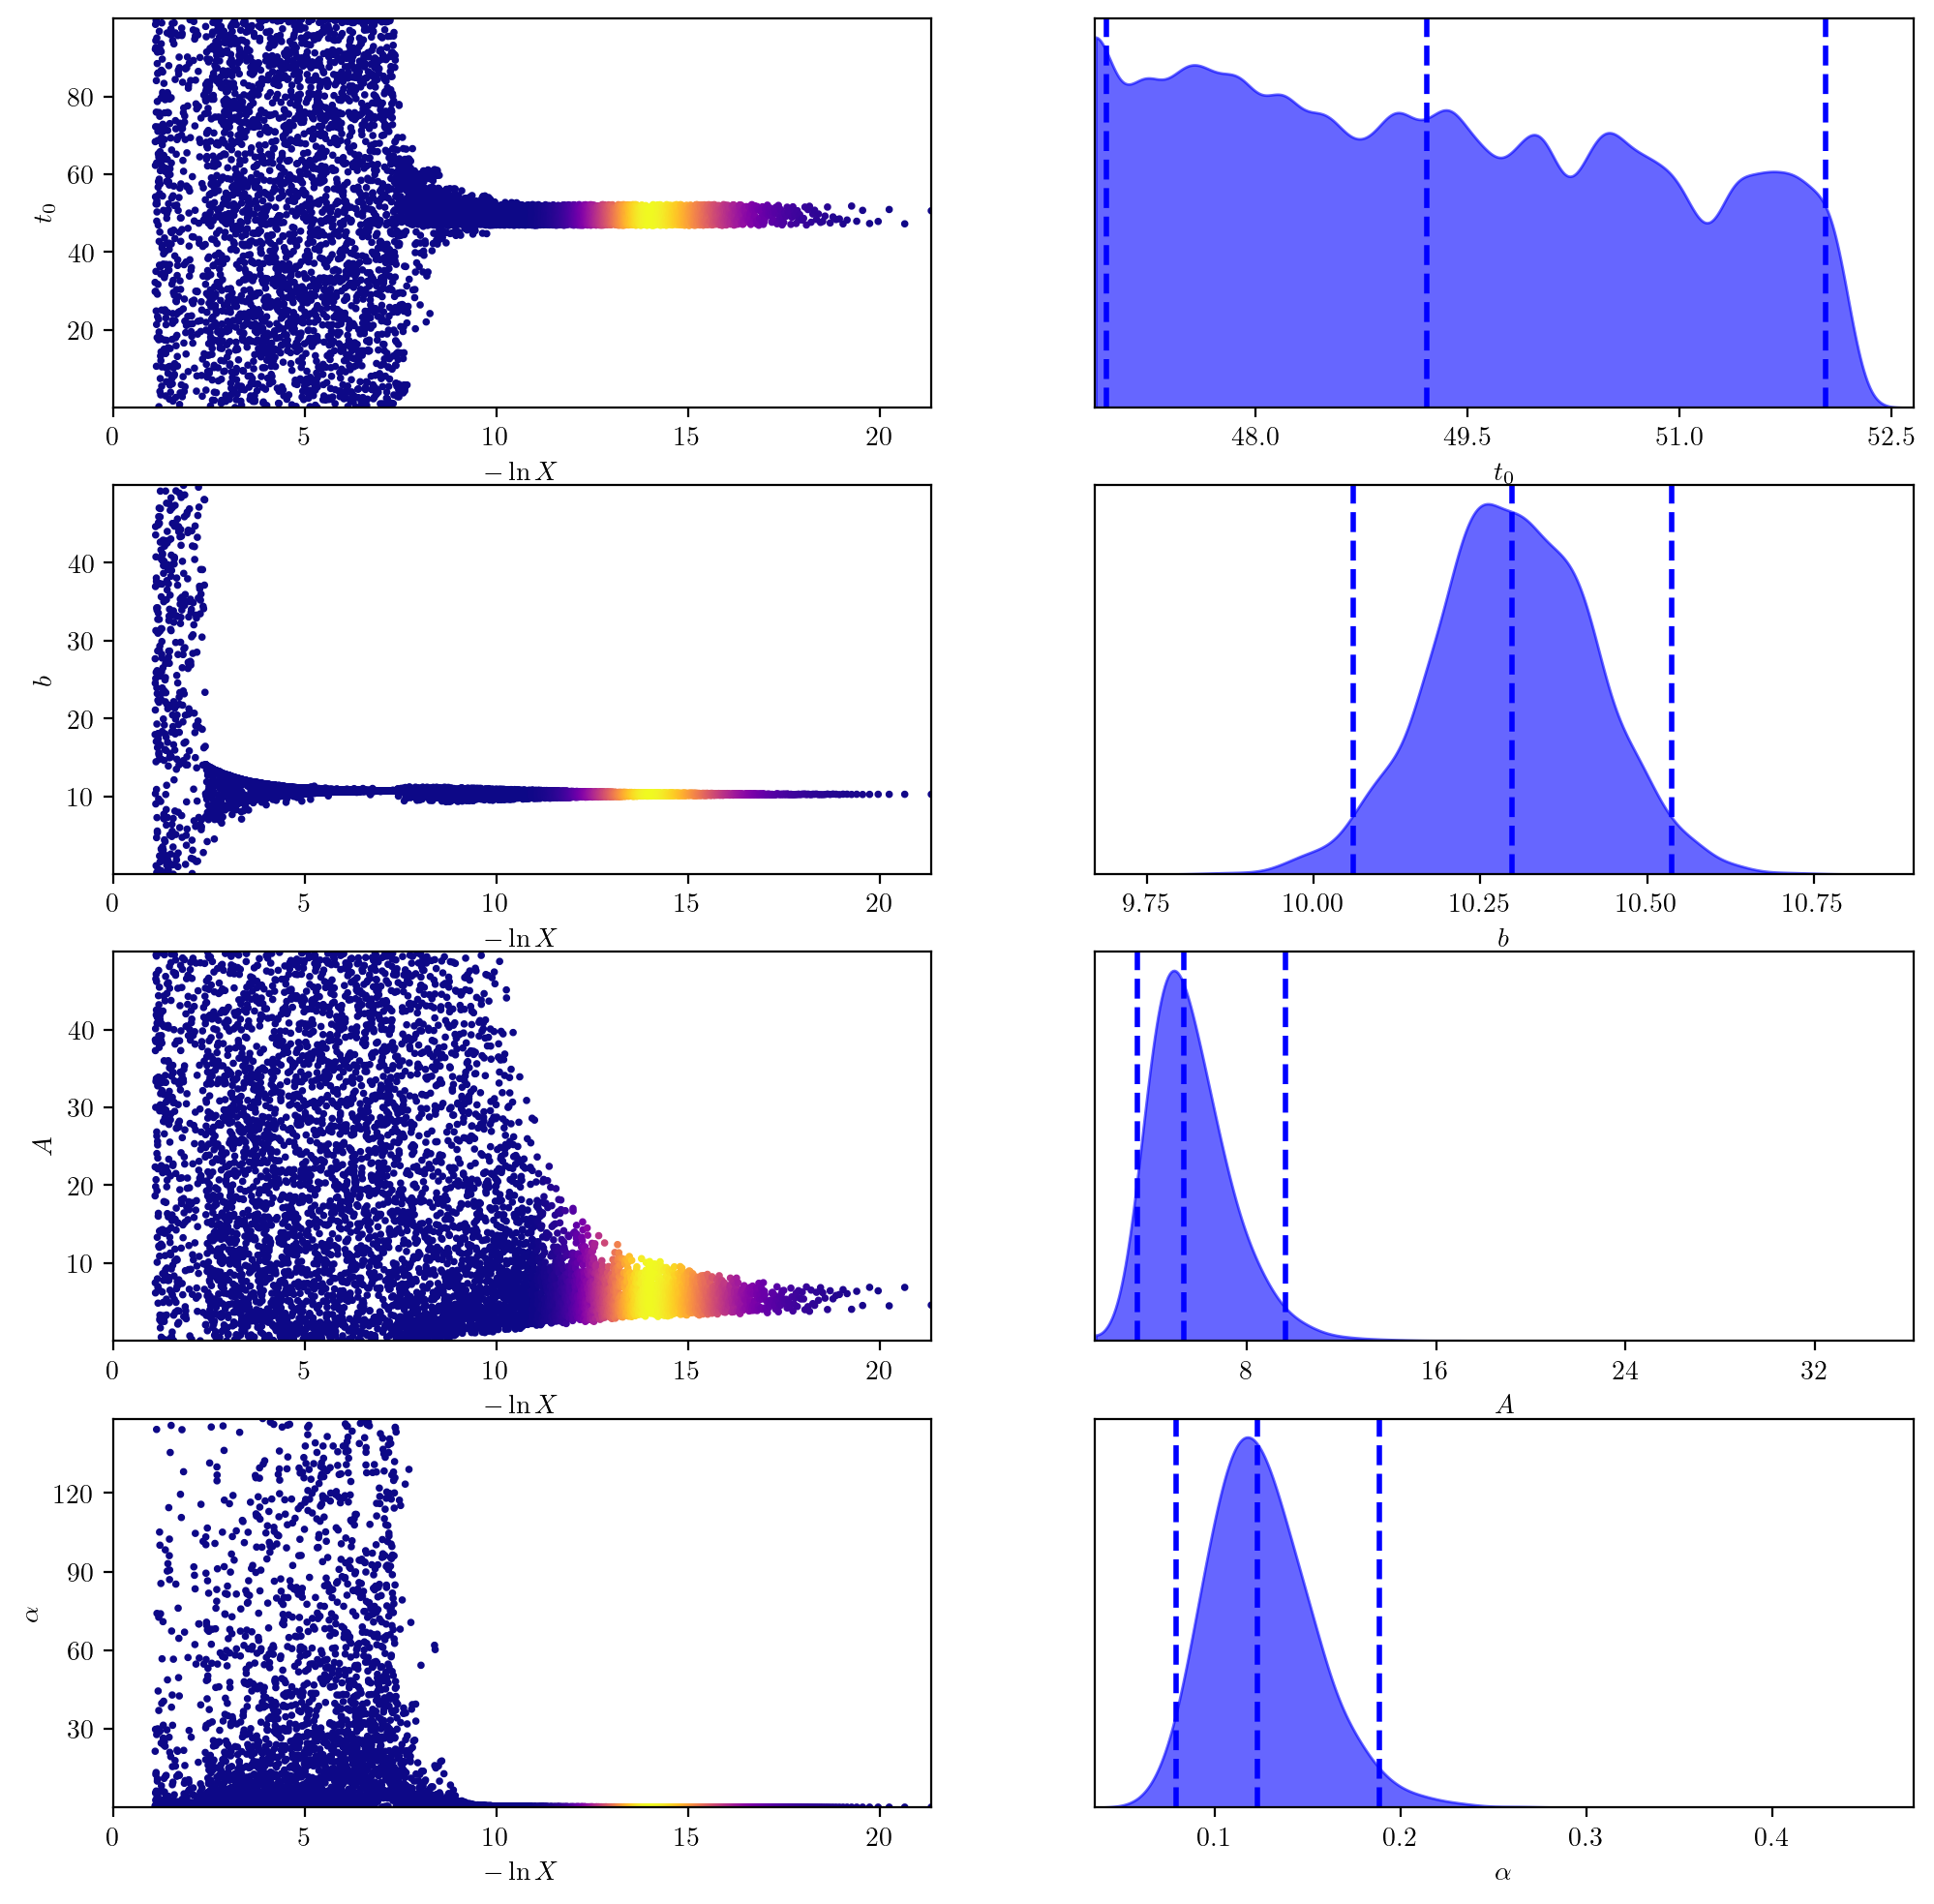

In [33]:
tfig, taxes = dyplot.traceplot(sresults, labels=labels)

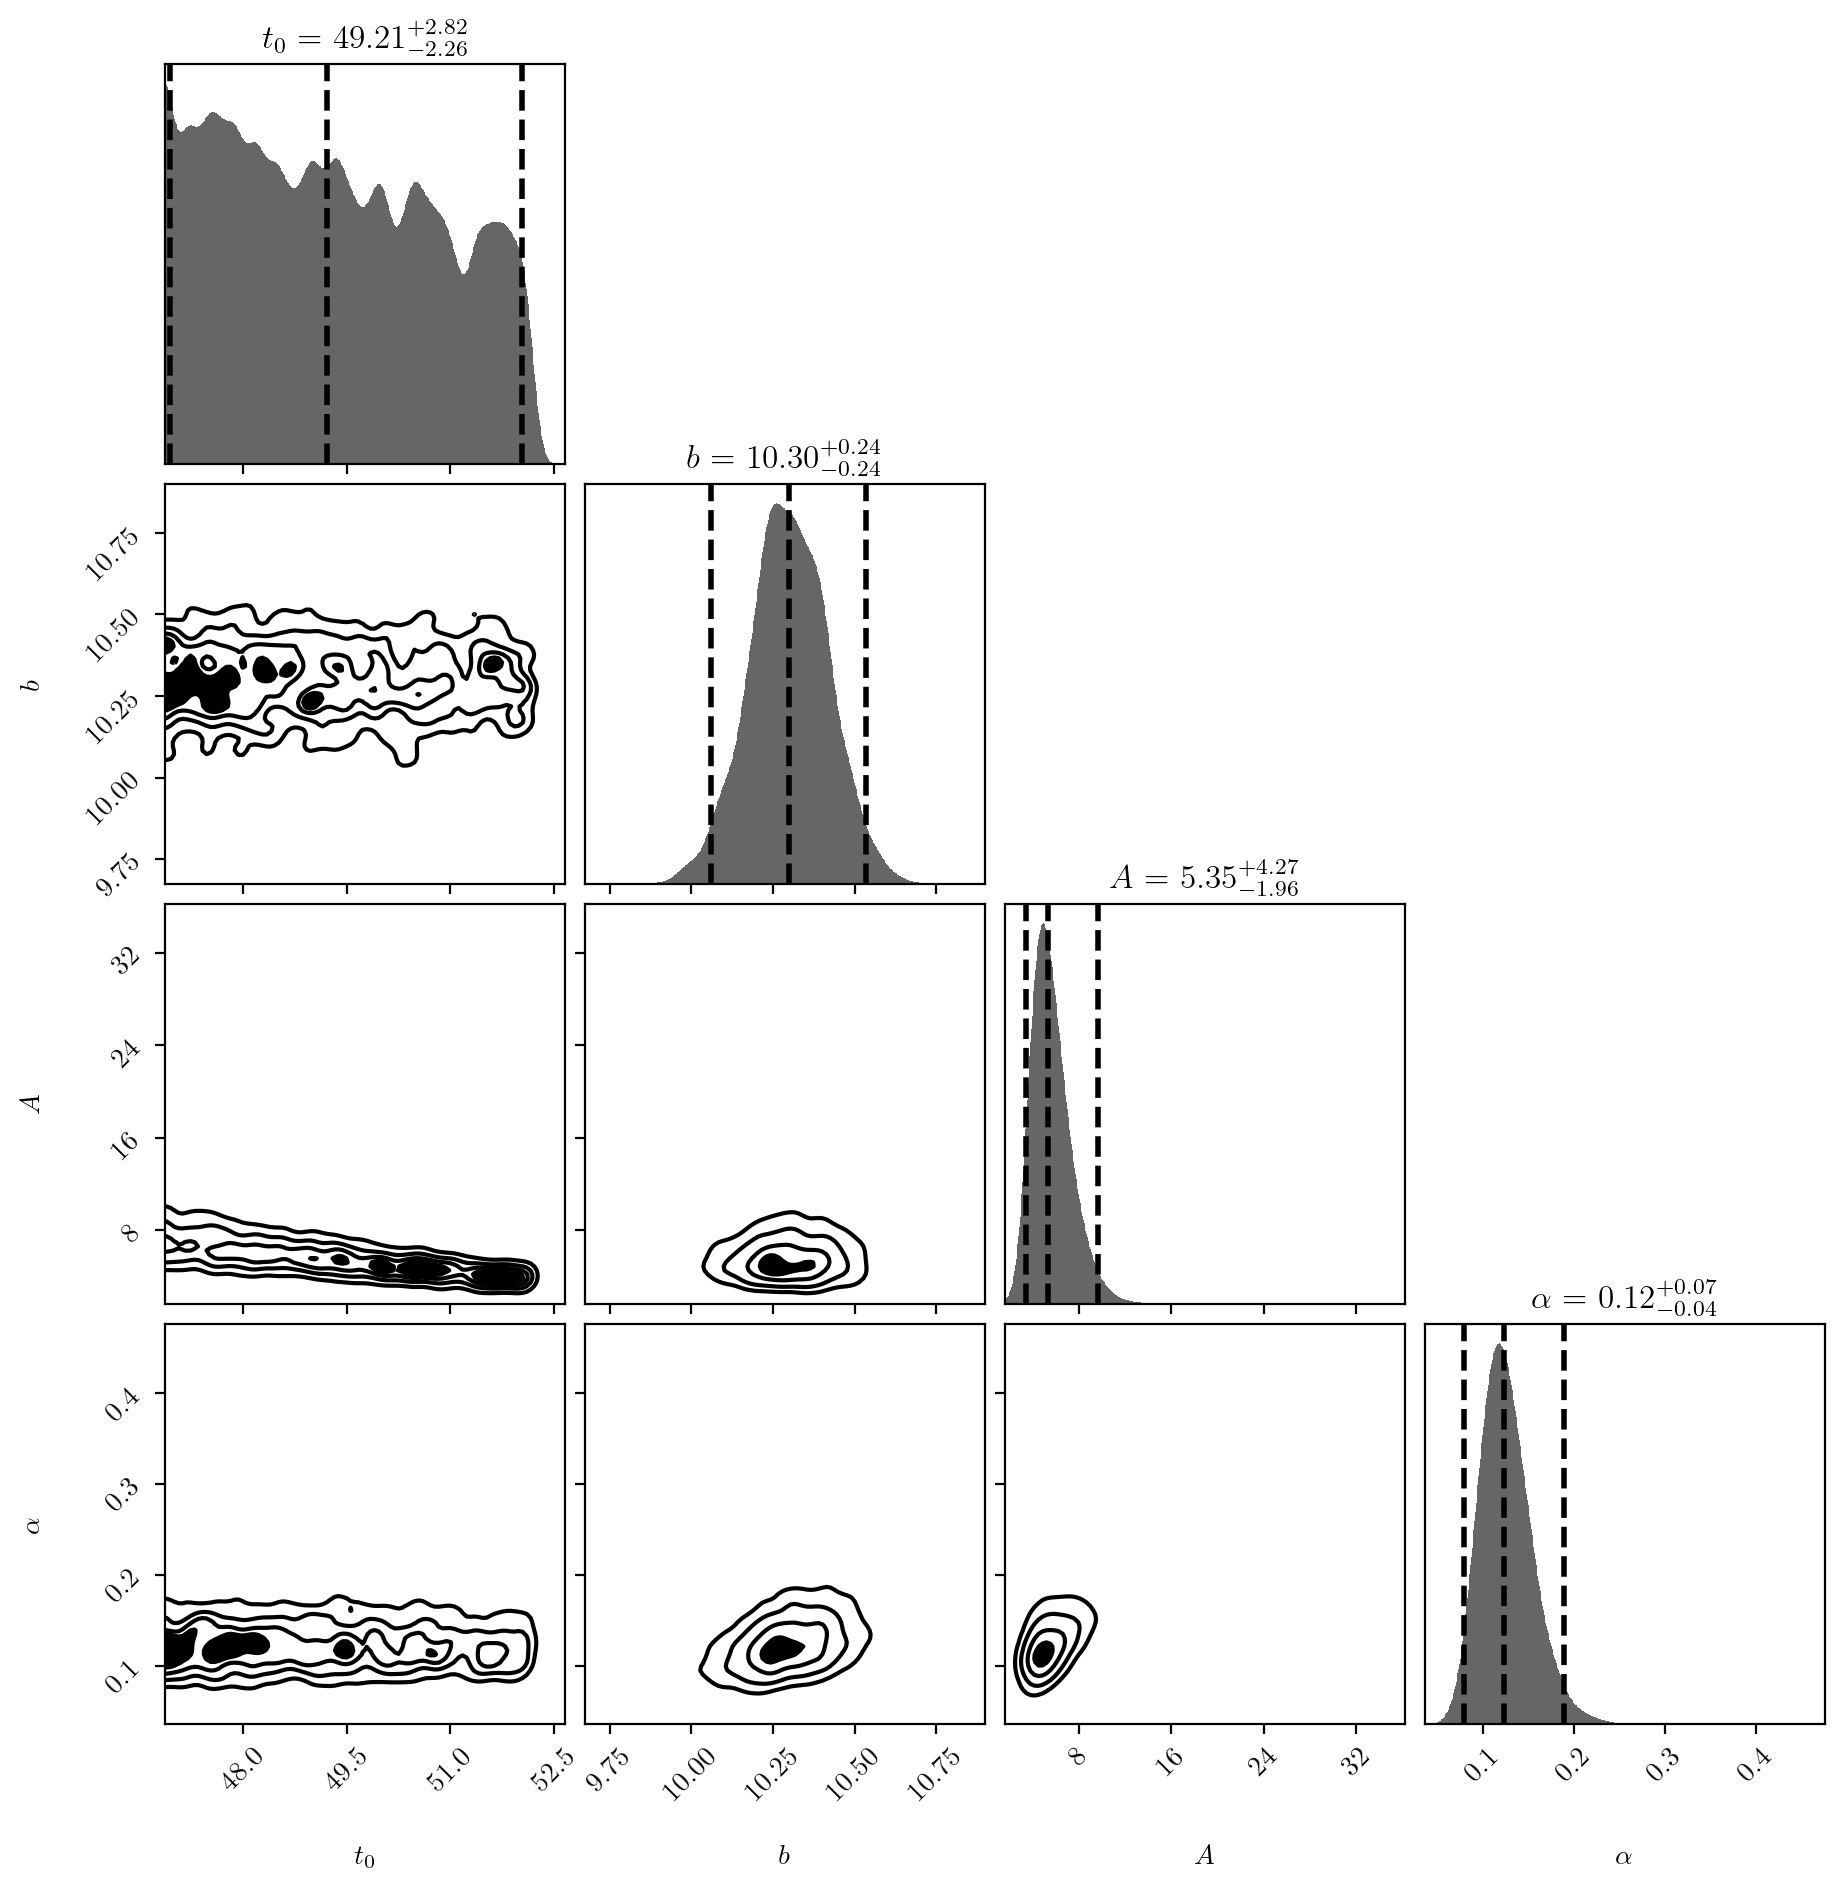

In [34]:
cfig, caxes = dyplot.cornerplot(sresults,labels=labels,show_titles=True)

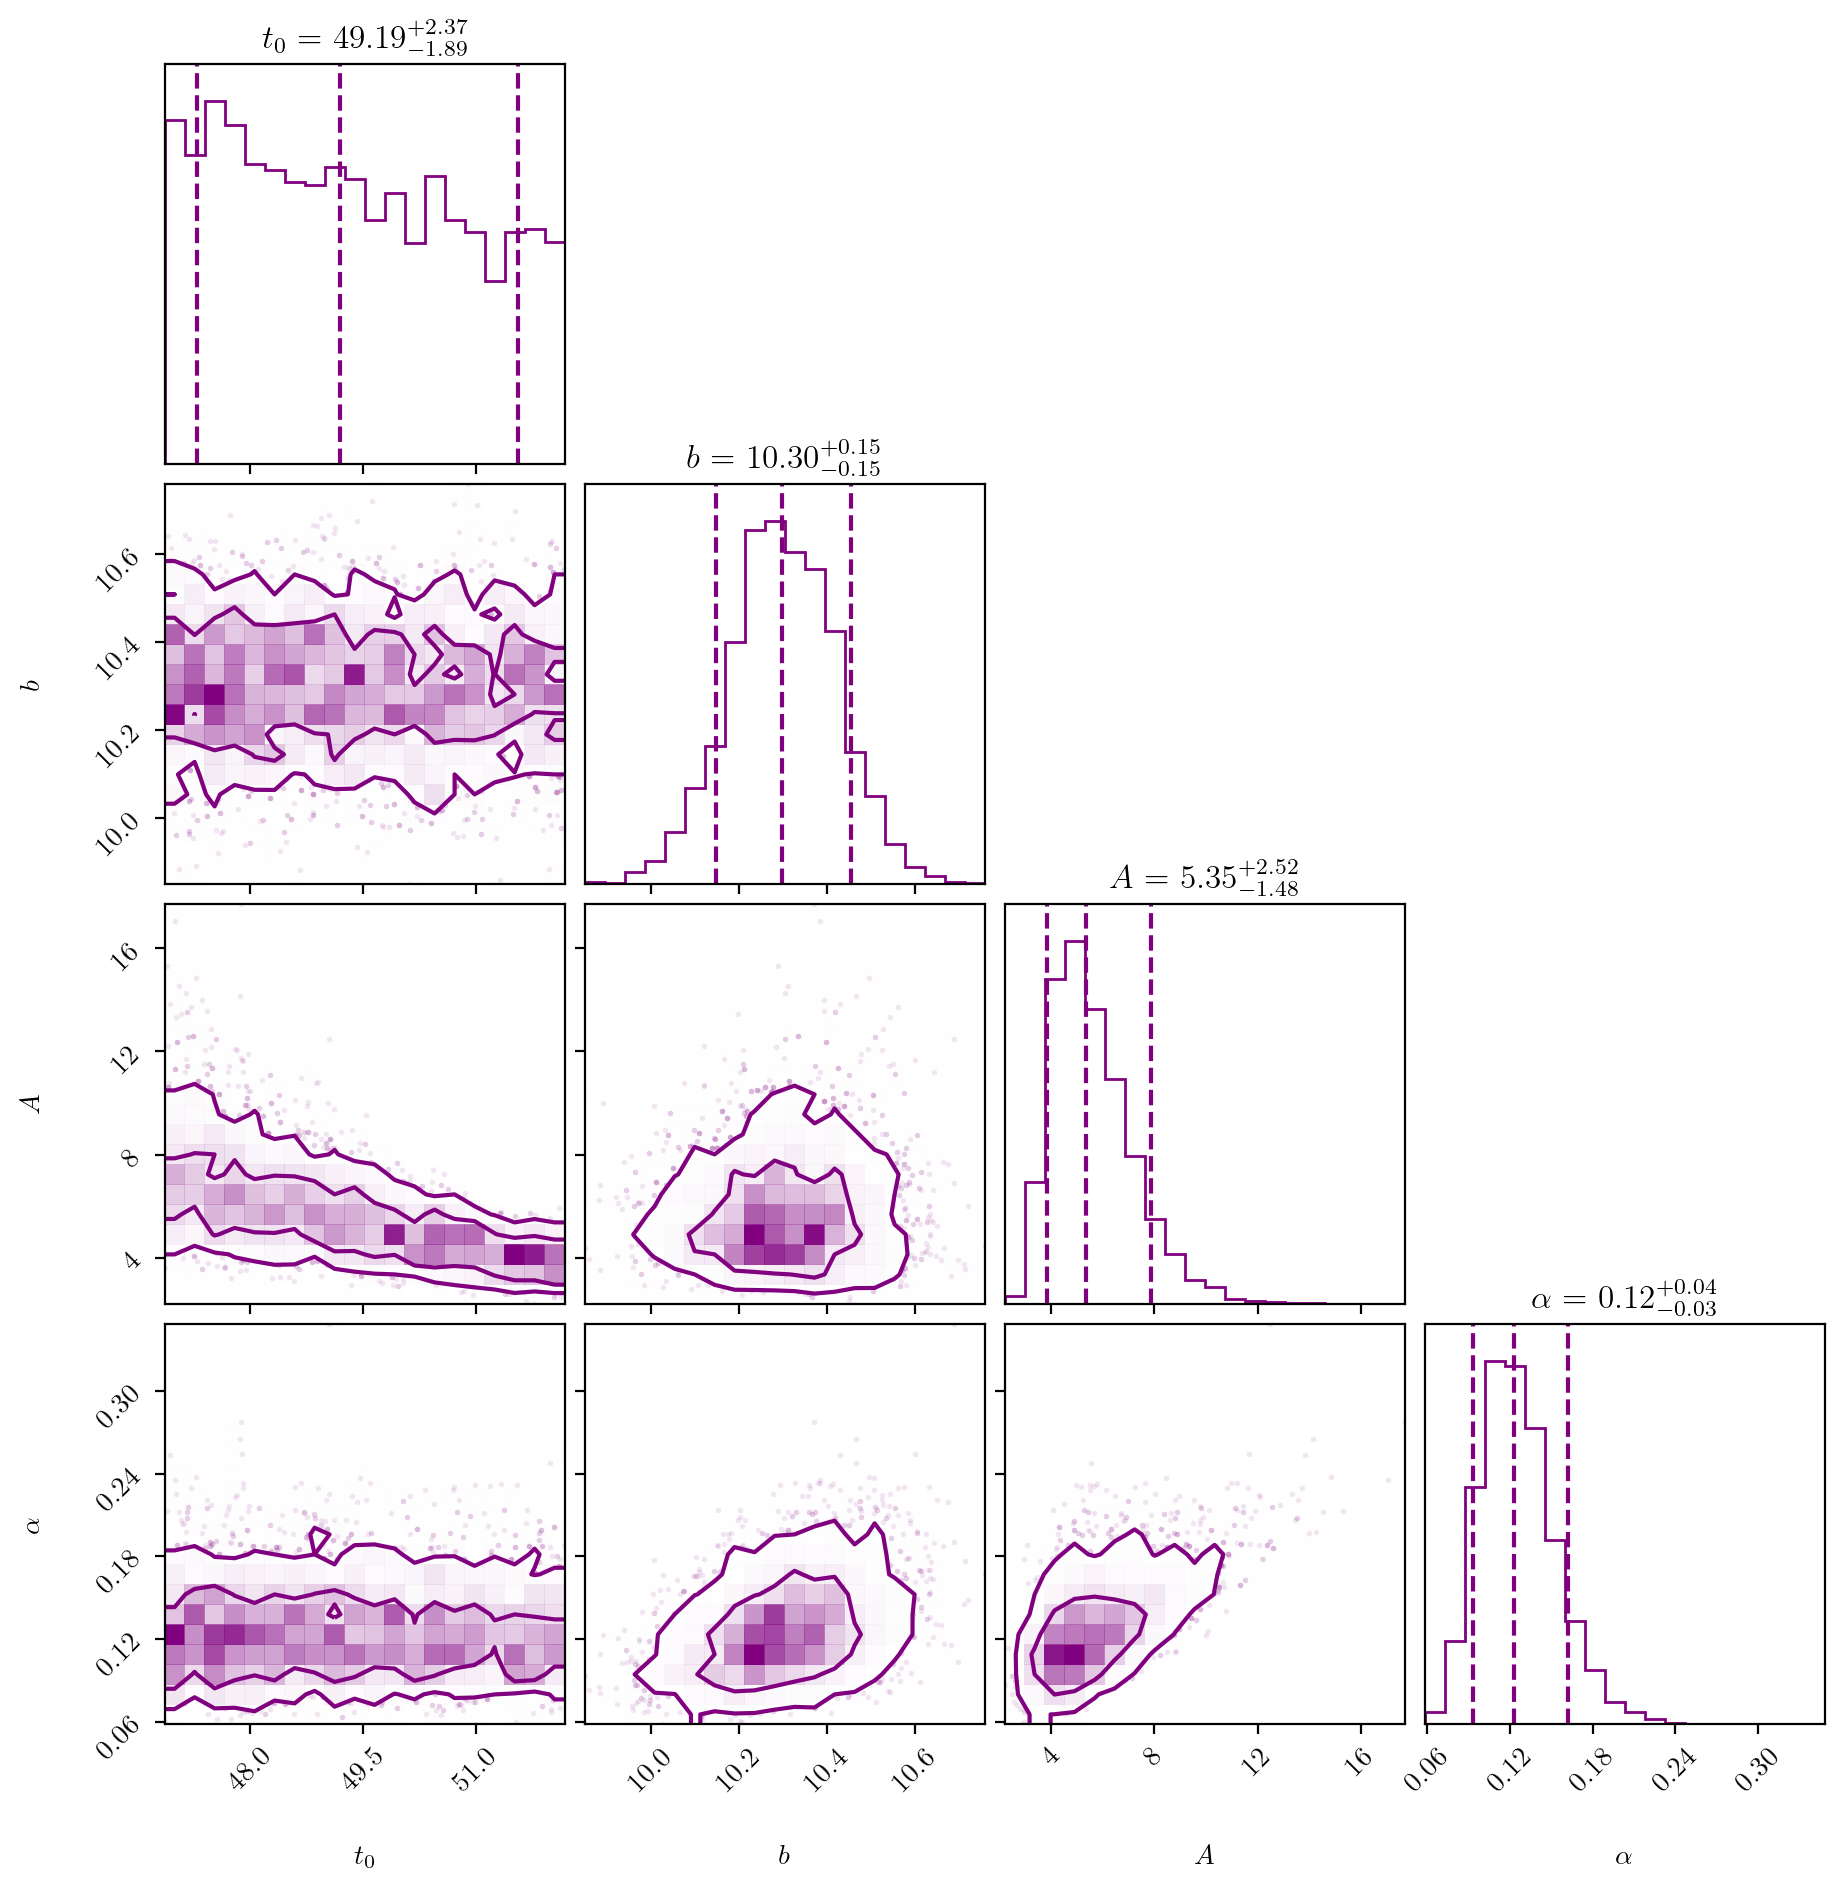

In [55]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

samples_equal = dyfunc.resample_equal(samples, weights)

labels = [r'$t_0$', r'$b$', r'$A$', r'$\alpha$']

fig = corner.corner(
    samples_equal,                      
    labels=labels,                        
    quantiles=[0.10, 0.5, 0.90],           
    show_titles=True,                      
    title_fmt=".2f",                       
    levels=(0.68, 0.95),                  
    plot_density=True,                                       
    color='purple'                           
)

fig.show()

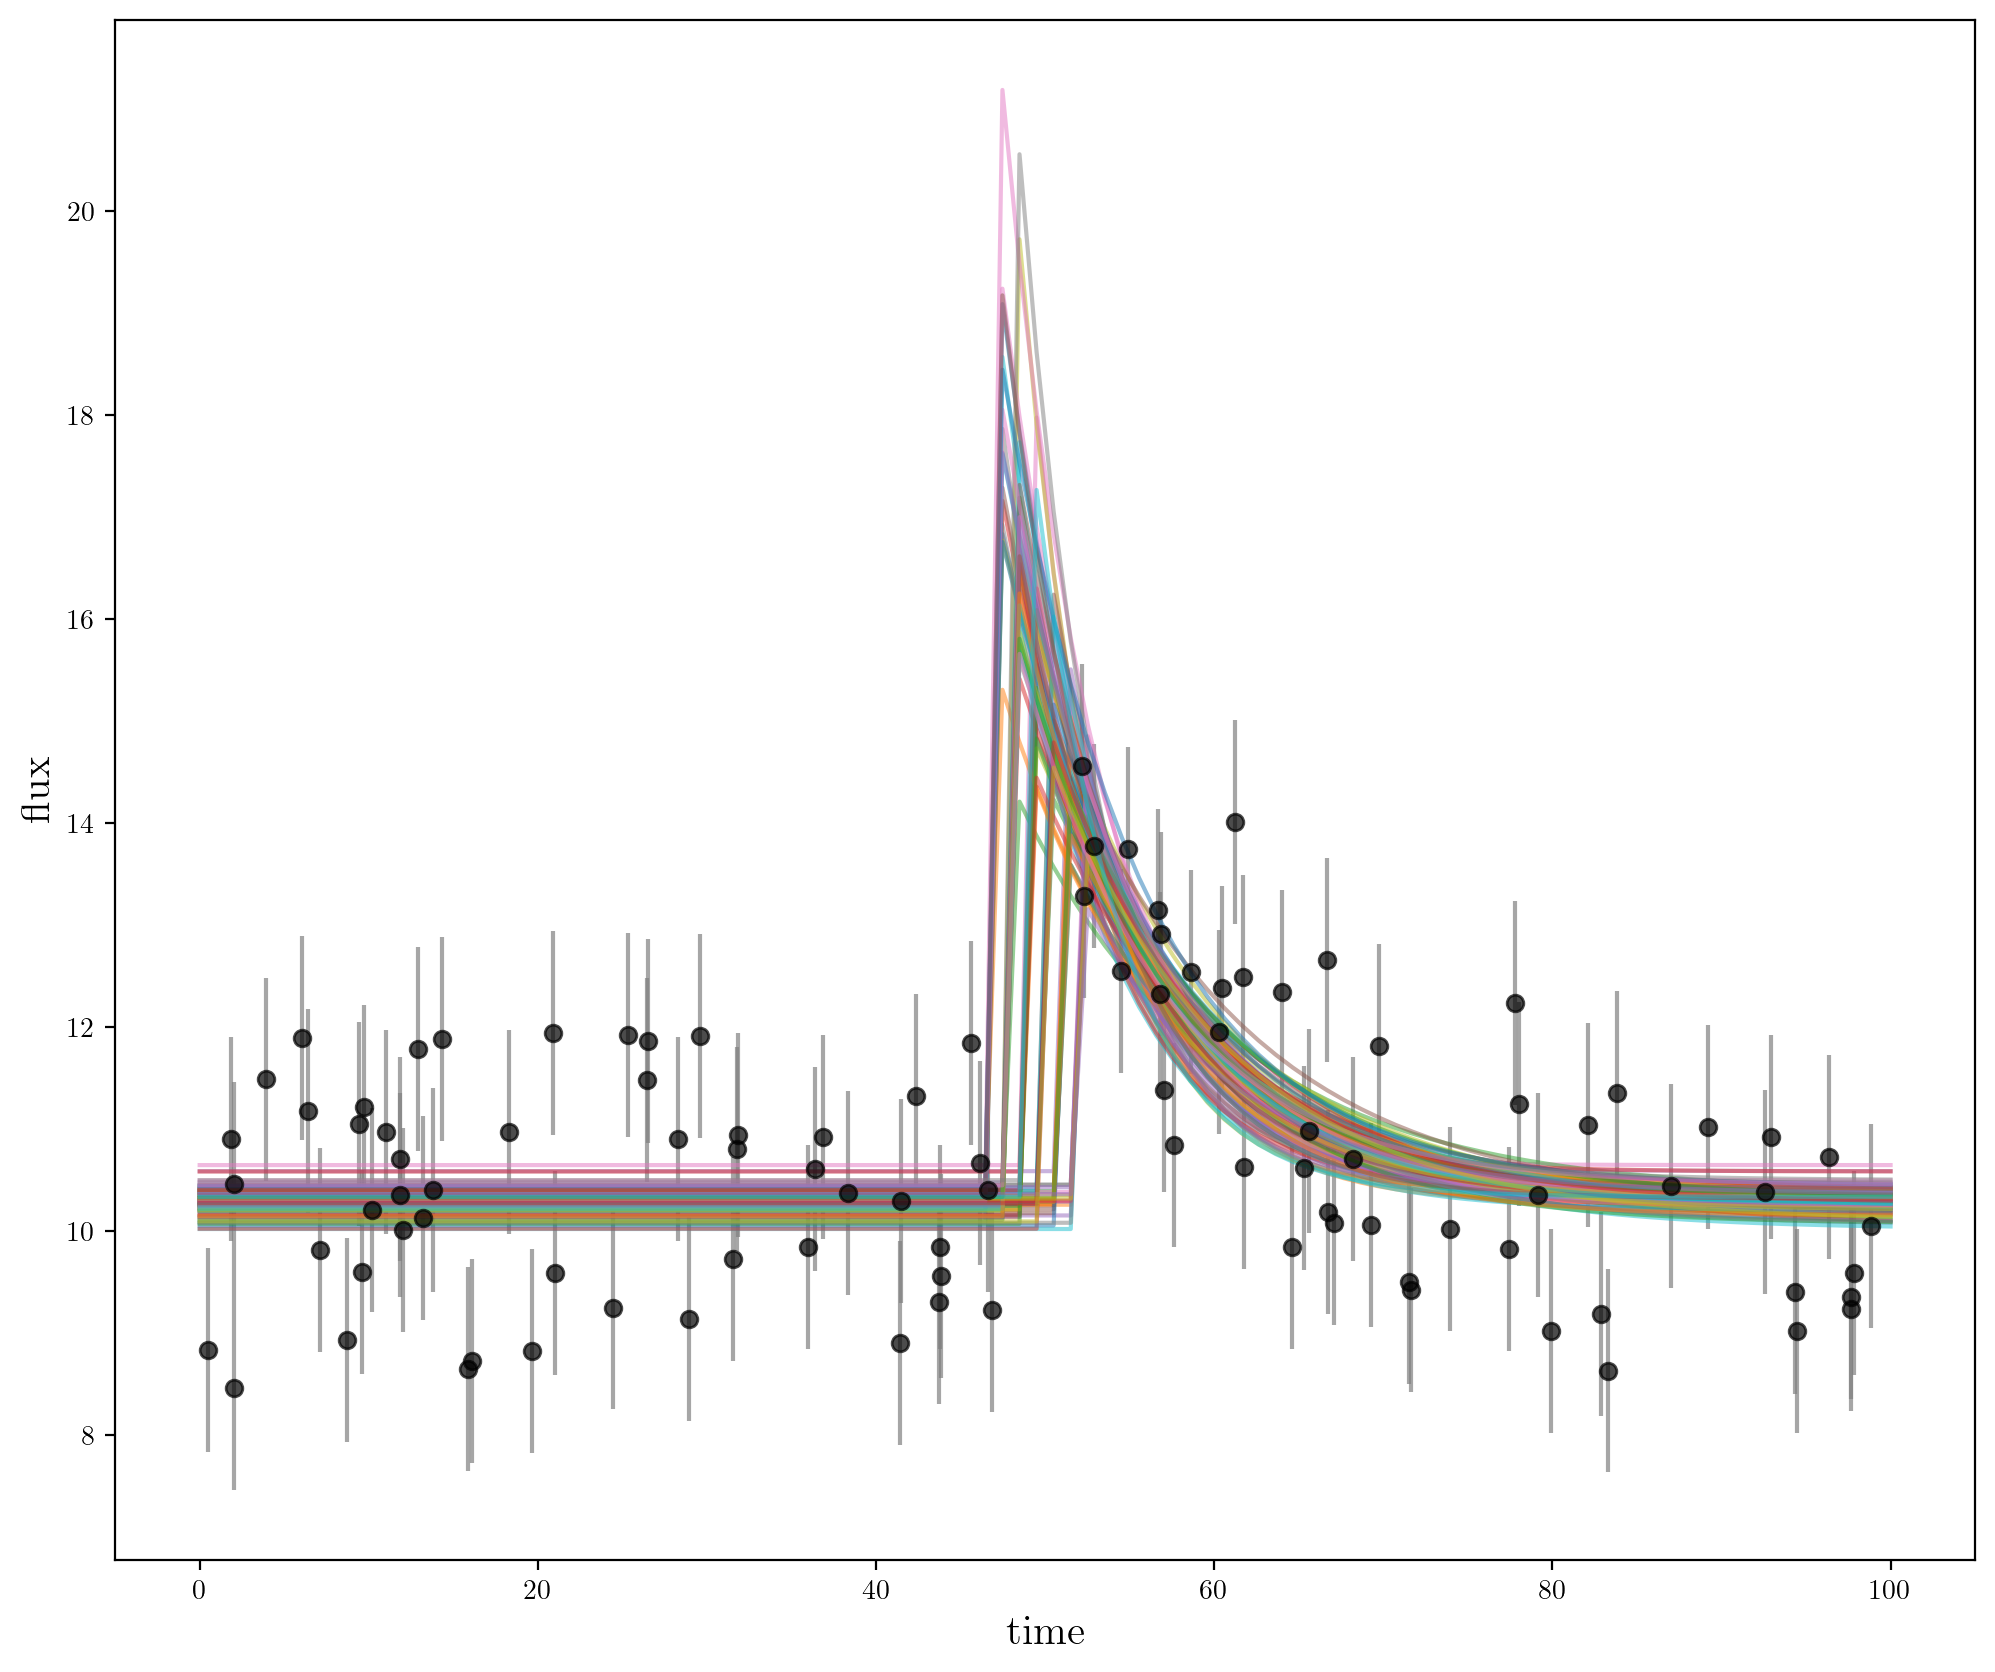

In [206]:
tgrid=np.linspace(0,100,100)

fig = plt.figure(figsize=(12, 10))
plt.errorbar(time, flux, yerr=err_flux, color='black', ecolor='grey', fmt='o', alpha=0.7)

samples = np.random.choice(np.arange(0, len(samples_equal)), size=100, replace=False)
chosen_samples= samples_equal[samples]

for chosen_theta in chosen_samples:
    t0, b, A, alpha = chosen_theta
    ygrid =  burst(tgrid,t0, b, A, alpha)
    plt.plot(tgrid,ygrid,alpha=0.5)

plt.xlabel('time',fontsize=15)
plt.ylabel('flux',fontsize=15)
plt.show()

### Gaussian Model

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

In [36]:
def gaus_burst(t, t0, b, A, s):
    return b + A * np.exp(- ((t - t0)**2)/(2*s**2))

In [37]:
def likelihood(params, t, y_obs, sigma):
    t0, b, A, s = params 
    
    y_pred = gaus_burst(t, t0, b, A, s)

    # Calcolo dei residui
    residuals = y_obs - y_pred

    # Likelihood normale
    L = np.exp(-0.5 * np.sum((residuals / sigma) ** 2 + np.log(2 * np.pi * sigma**2)))
    
    return L

def neg_log_likelihood(params, t, y_obs, sigma):
    return -np.log(likelihood(params, t, y_obs, sigma))

Basic Fit minimizing likelihood

In [57]:

sigma = err_flux[0]

# Initial guess for the parameters
initial_params = [50.0, 10.0, 5.0, 5.0]

result = minimize(neg_log_likelihood, initial_params, args=(time, flux, sigma))
best_params = result.x
t0, b, A, s = best_params
print('Best parameters from the likelihood minimizaion:', best_params)

Best parameters from the likelihood minimizaion: [55.47276    10.30690945  2.7510915   5.36990226]


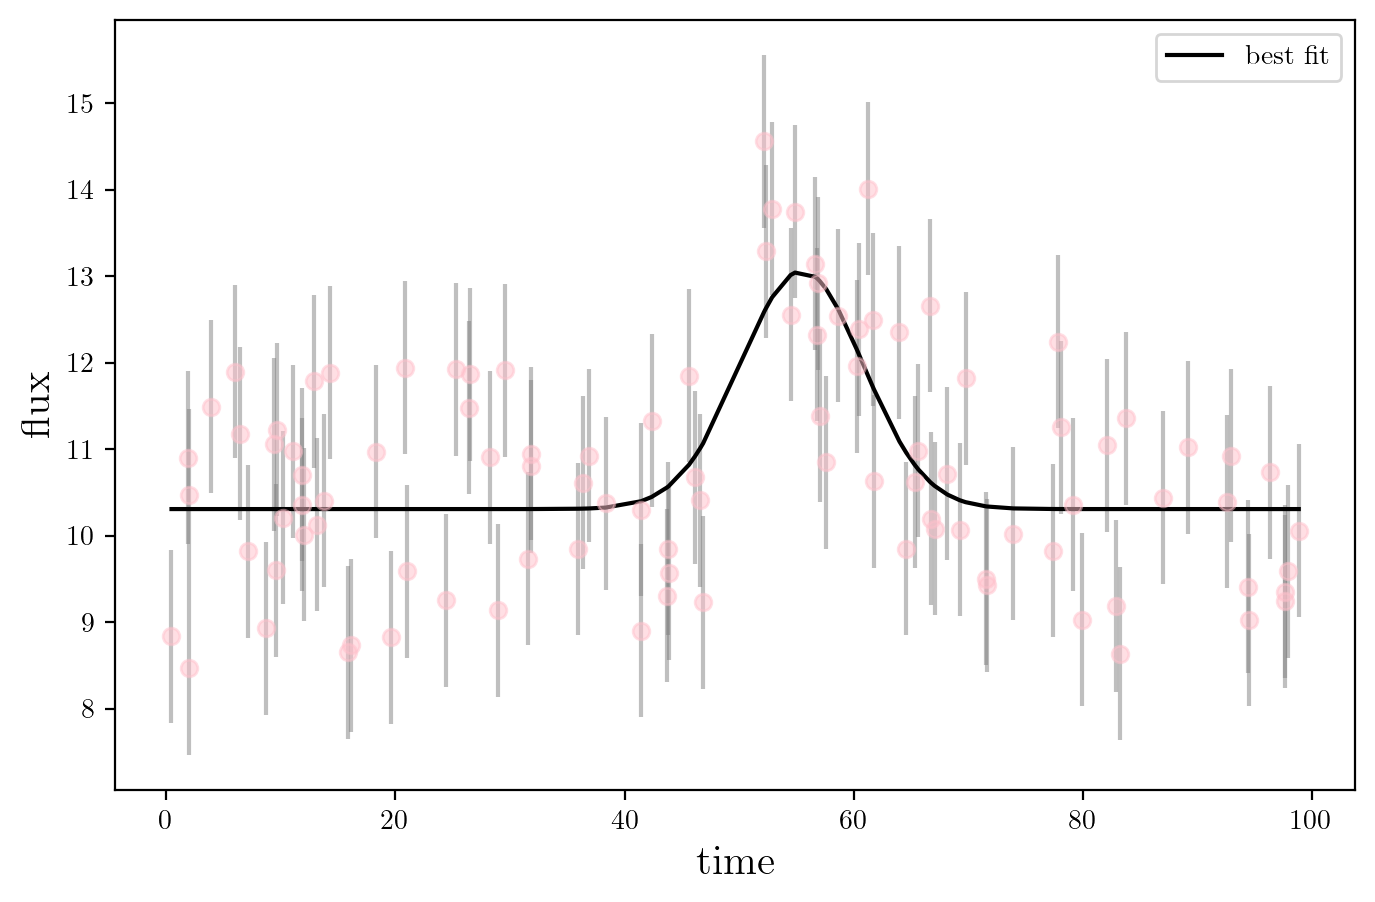

In [39]:
fig = plt.figure(figsize=(8, 5))
plt.errorbar(time, flux, yerr=err_flux, ecolor='grey', color='pink', fmt='o', alpha=0.5)
plt.plot(time, gaus_burst(time, t0, b, A, s), color='black', label='best fit')

plt.xlabel('time',fontsize=15)
plt.ylabel('flux',fontsize=15)
plt.legend()
plt.show()

In [40]:
new_params_prior = [
    (0, 100),   # t0
    (0, 50),    # b
    (0, 50),    # A
    (0, 10)   # s (gaus prior)
]

In [41]:
def new_prior_transform(u):
    t0 = nest_flat_prior(u[0], new_params_prior[0][0], new_params_prior[0][1])
    A  = nest_flat_prior(u[1], new_params_prior[1][0], new_params_prior[1][1])
    b  = nest_flat_prior(u[2], new_params_prior[2][0], new_params_prior[2][1])
    s = nest_logflat_prior(u[3], new_params_prior[3][0], new_params_prior[3][1]) 
    #same prior as alpha so then I can use just bayes factor to compare
    
    return [t0, A, b, s]

In [42]:
#increase the live points to try to avoid problems in campionamento 
new_sampler = dynesty.NestedSampler(norm_loglike, new_prior_transform, ndim) 
new_sampler.run_nested()
new_sresults = new_sampler.results

/tmp/ipykernel_2276/3617051522.py:5: RuntimeWarning: divide by zero encountered in log
  logL = np.log(likelihood(params, time, flux, sigma))
0it [00:00, ?it/s]/tmp/ipykernel_2276/3617051522.py:5: RuntimeWarning: divide by zero encountered in log
  logL = np.log(likelihood(params, time, flux, sigma))
91it [00:00, 139.38it/s, bound: 1 | nc: 7 | ncall: 1641 | eff(%):  5.545 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509] /tmp/ipykernel_2276/3617051522.py:5: RuntimeWarning: divide by zero encountered in log
  logL = np.log(likelihood(params, time, flux, sigma))
203it [00:01, 193.49it/s, bound: 2 | nc: 16 | ncall: 2349 | eff(%):  8.642 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509]/tmp/ipykernel_2276/3617051522.py:5: RuntimeWarning: divide by zero encountered in log
  logL = np.log(likelihood(params, time, flux, sigma))
406it [00:02, 335.43it/s, bound: 3 | nc: 1 | ncall: 3164 | eff(%): 12.832 | loglstar:   -

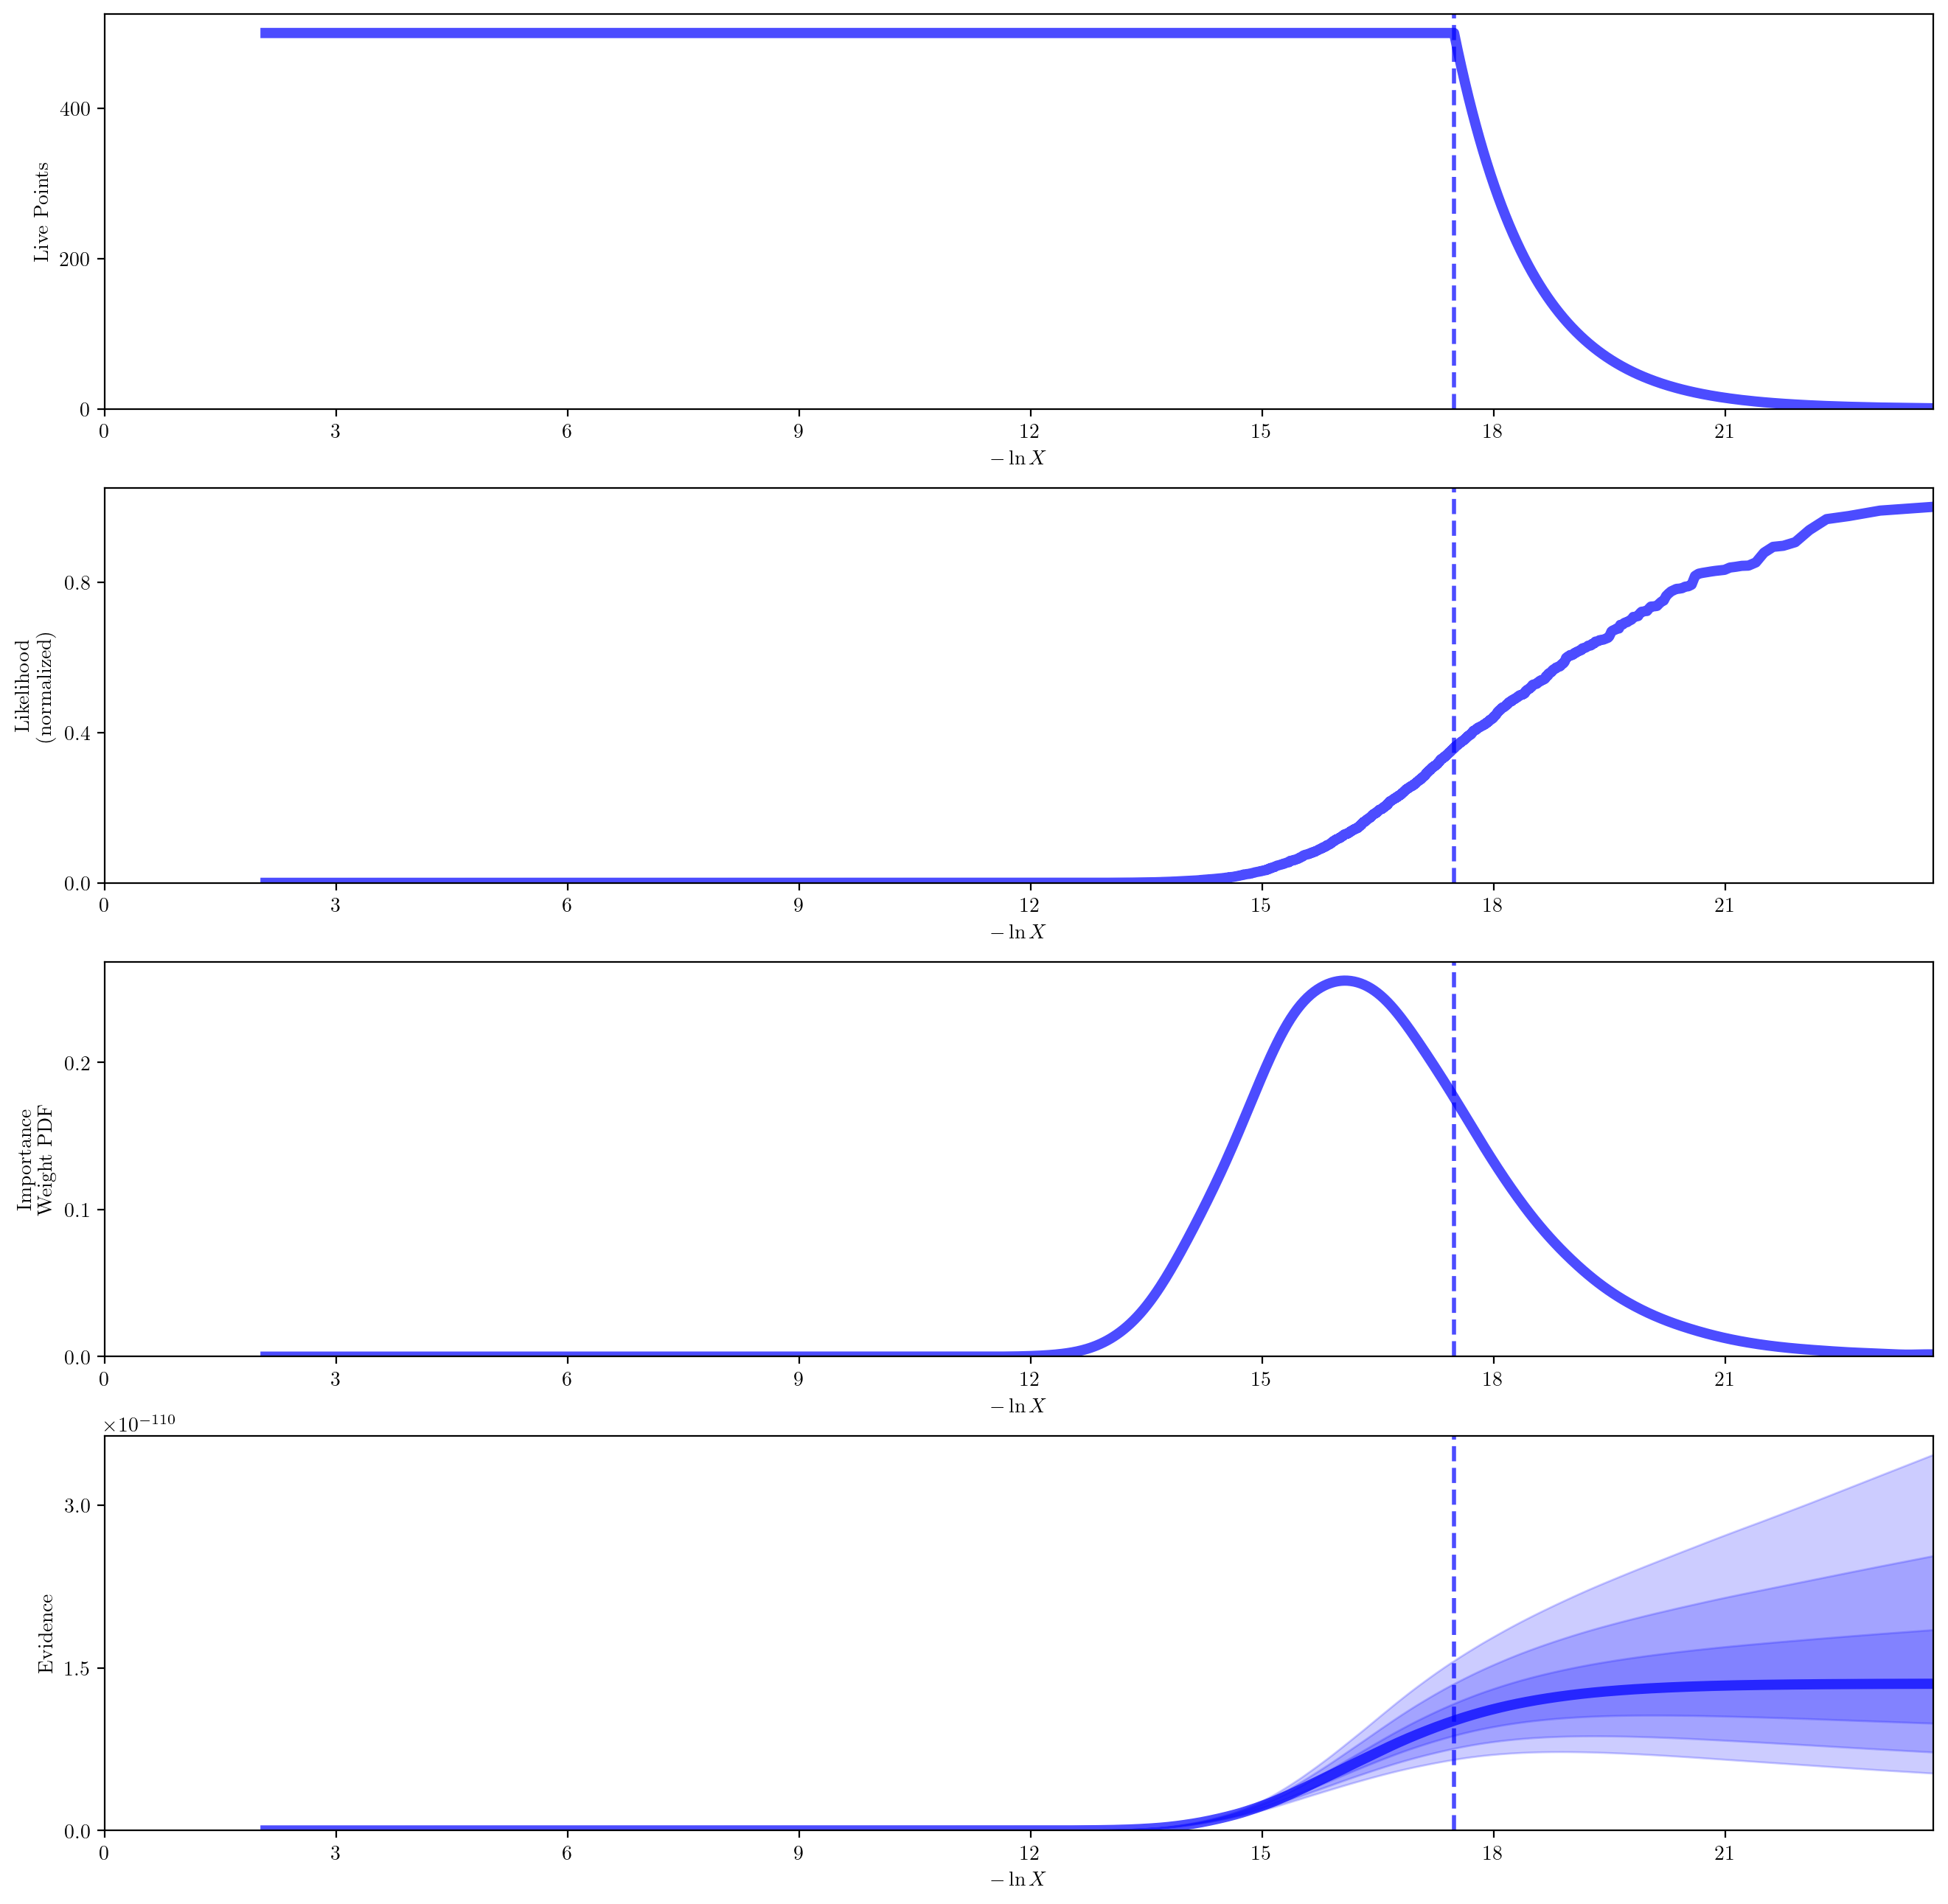

In [58]:
rfig, raxes = dyplot.runplot(new_sresults)

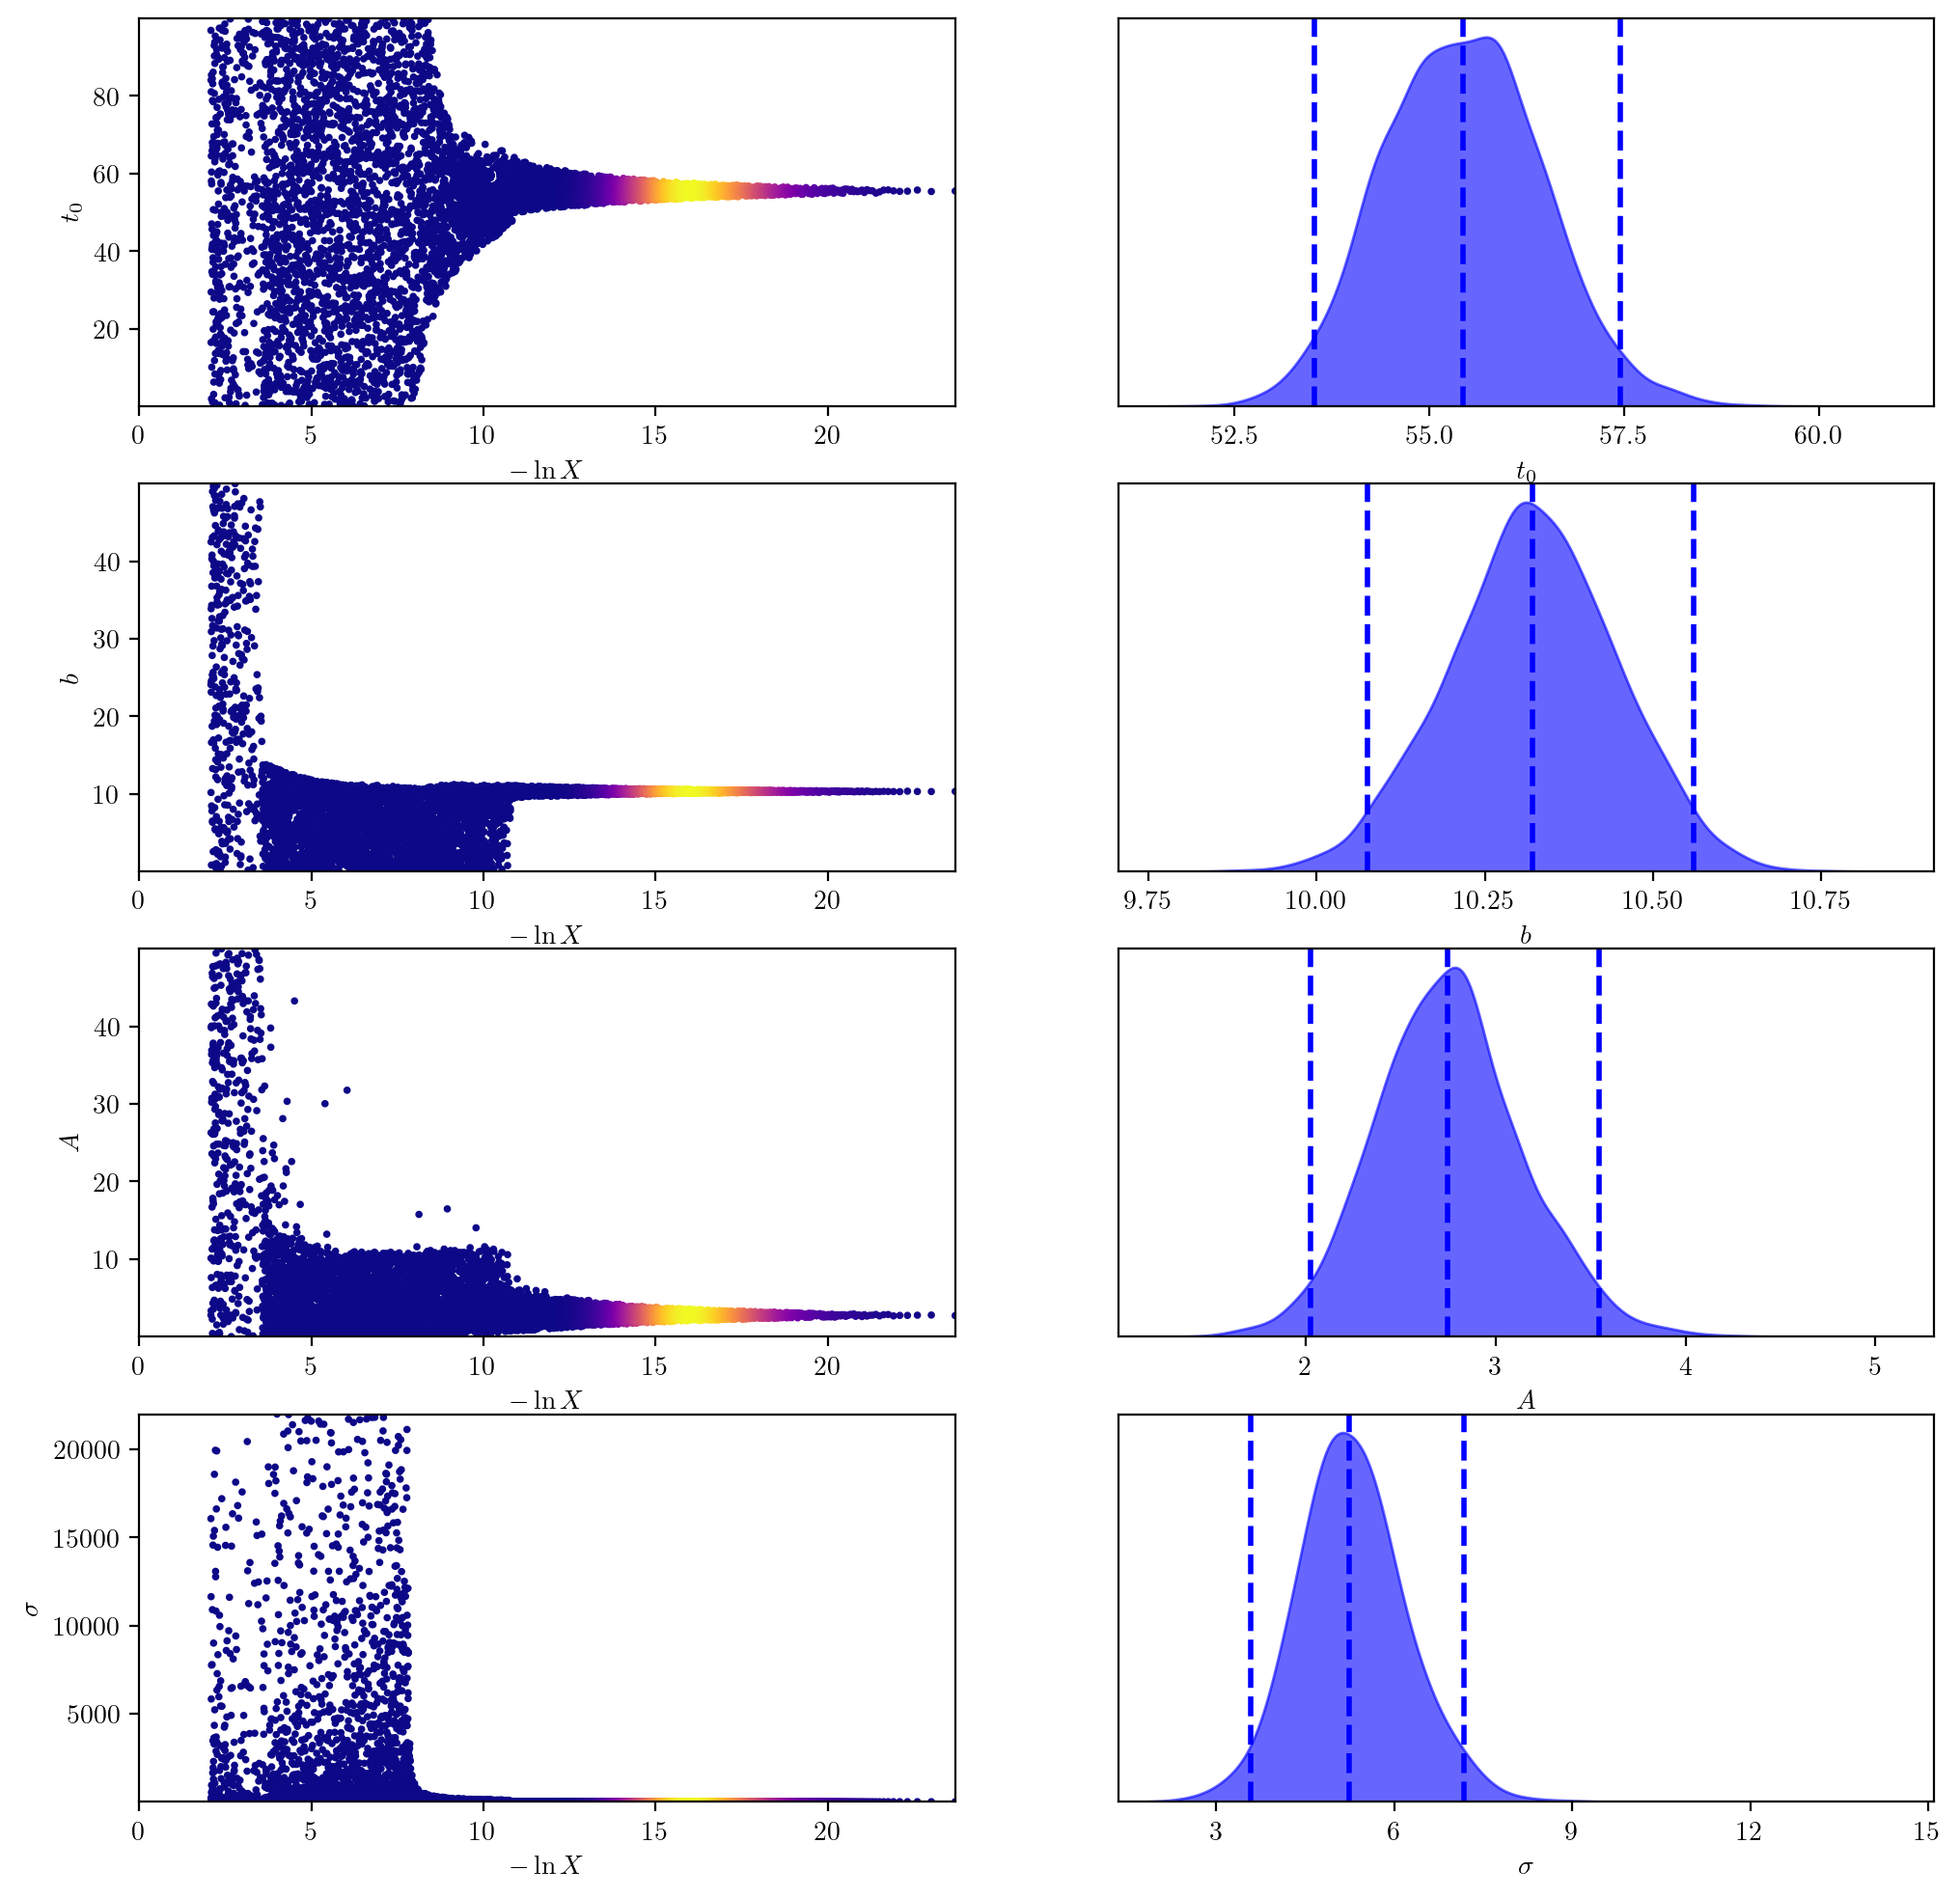

In [44]:
gaus_labels = [r'$t_0$', r'$b$', r'$A$', r'$\sigma$']
tfig, taxes = dyplot.traceplot(new_sresults, labels=gaus_labels)

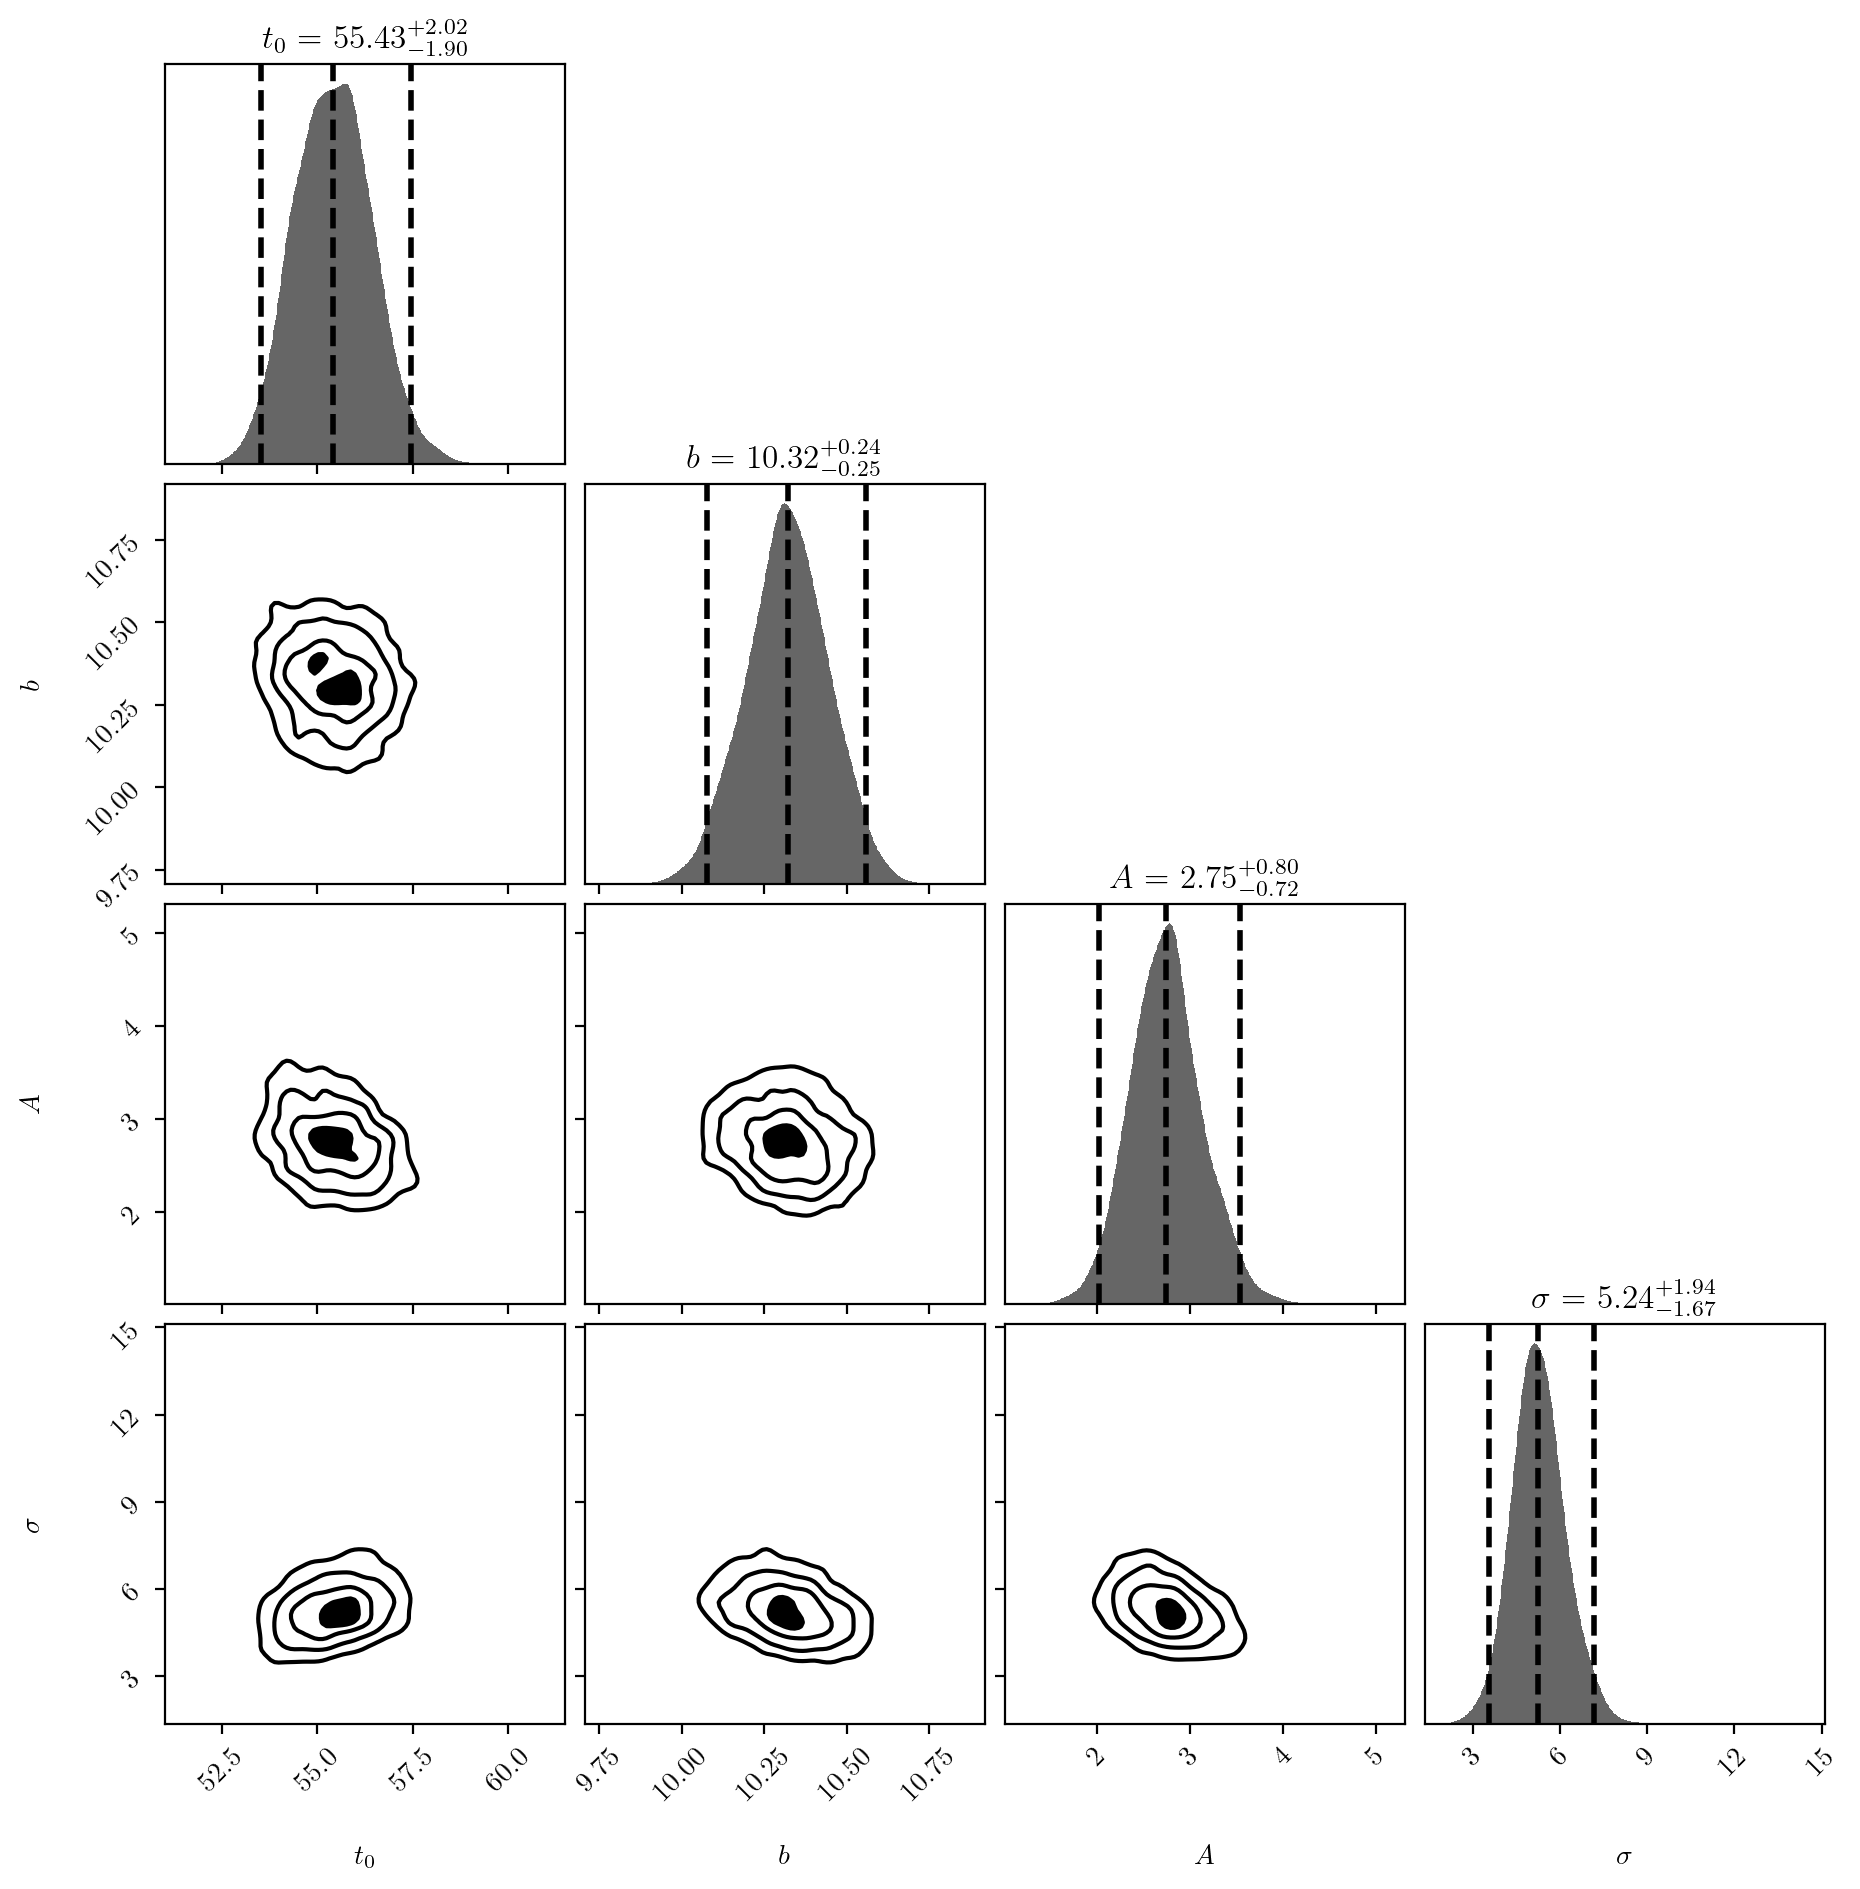

In [45]:
cfig, caxes = dyplot.cornerplot(new_sresults, labels=gaus_labels, show_titles=True)

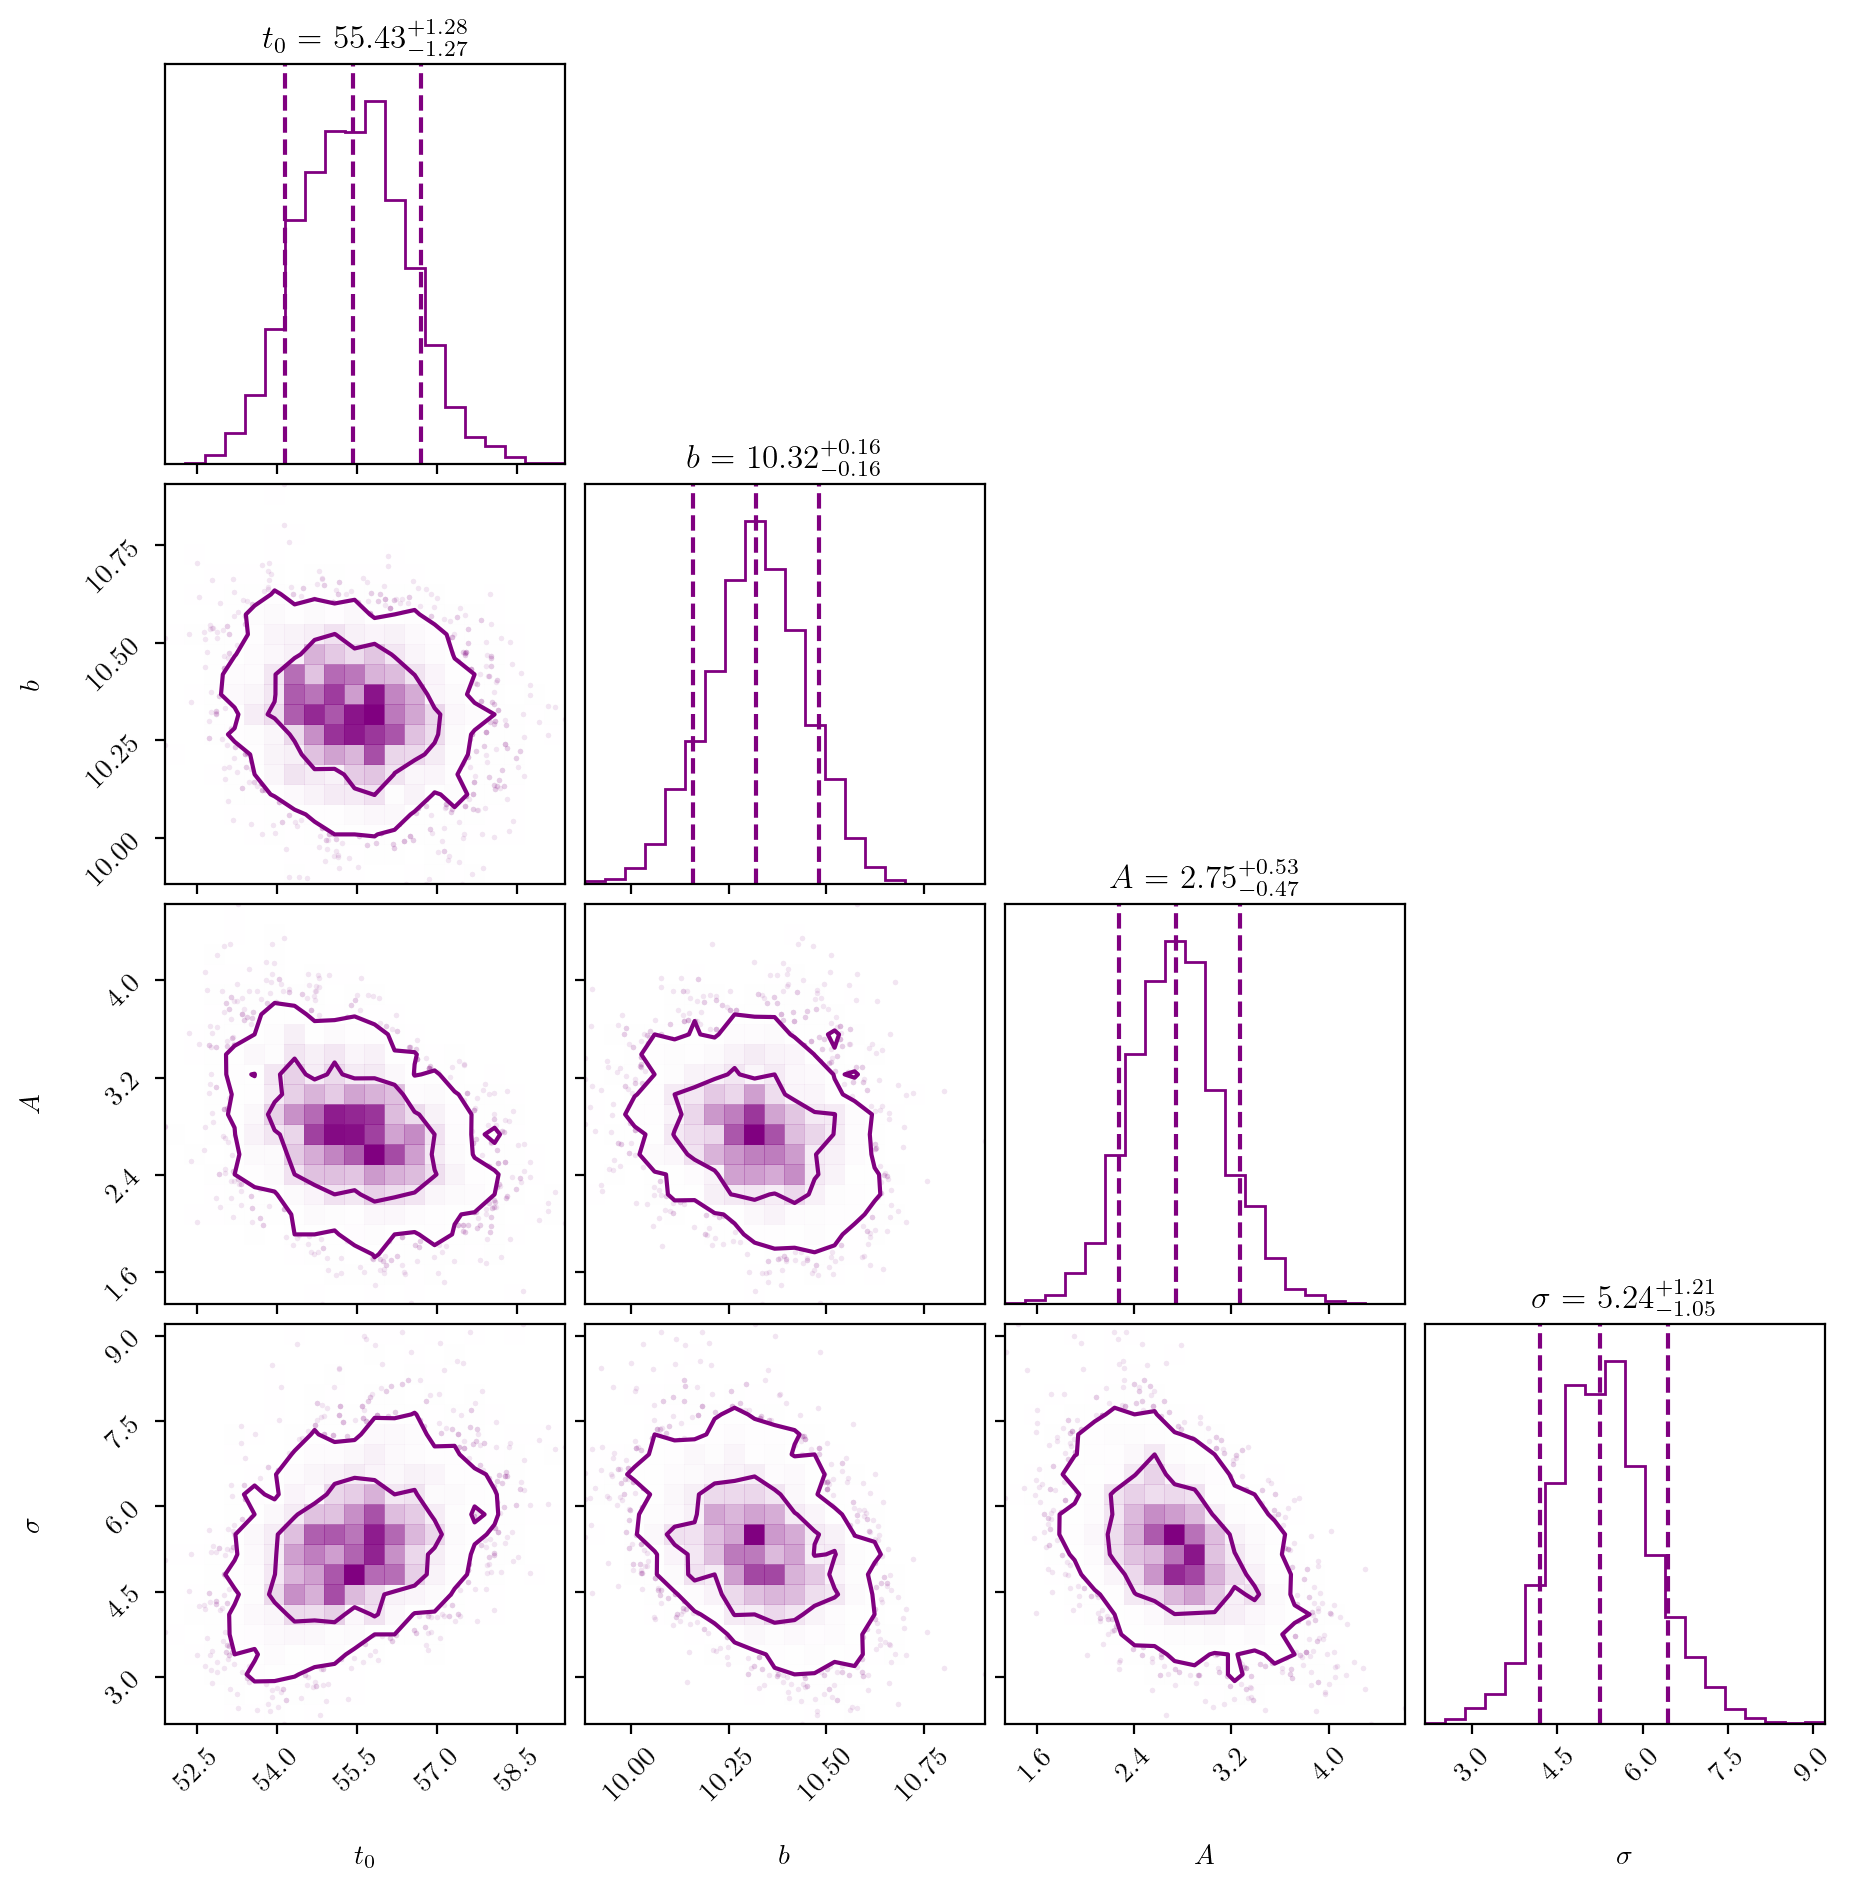

In [46]:
new_samples = new_sresults.samples  # samples
new_weights = np.exp(new_sresults.logwt - new_sresults.logz[-1])

new_samples_equal = dyfunc.resample_equal(new_samples, new_weights)

fig = corner.corner(
    new_samples_equal,                      
    labels=gaus_labels,                        
    quantiles=[0.10, 0.5, 0.90],           
    show_titles=True,                      
    title_fmt=".2f",                       
    levels=(0.68, 0.95),                  
    plot_density=True,                                       
    color='purple'                           
)

fig.show()

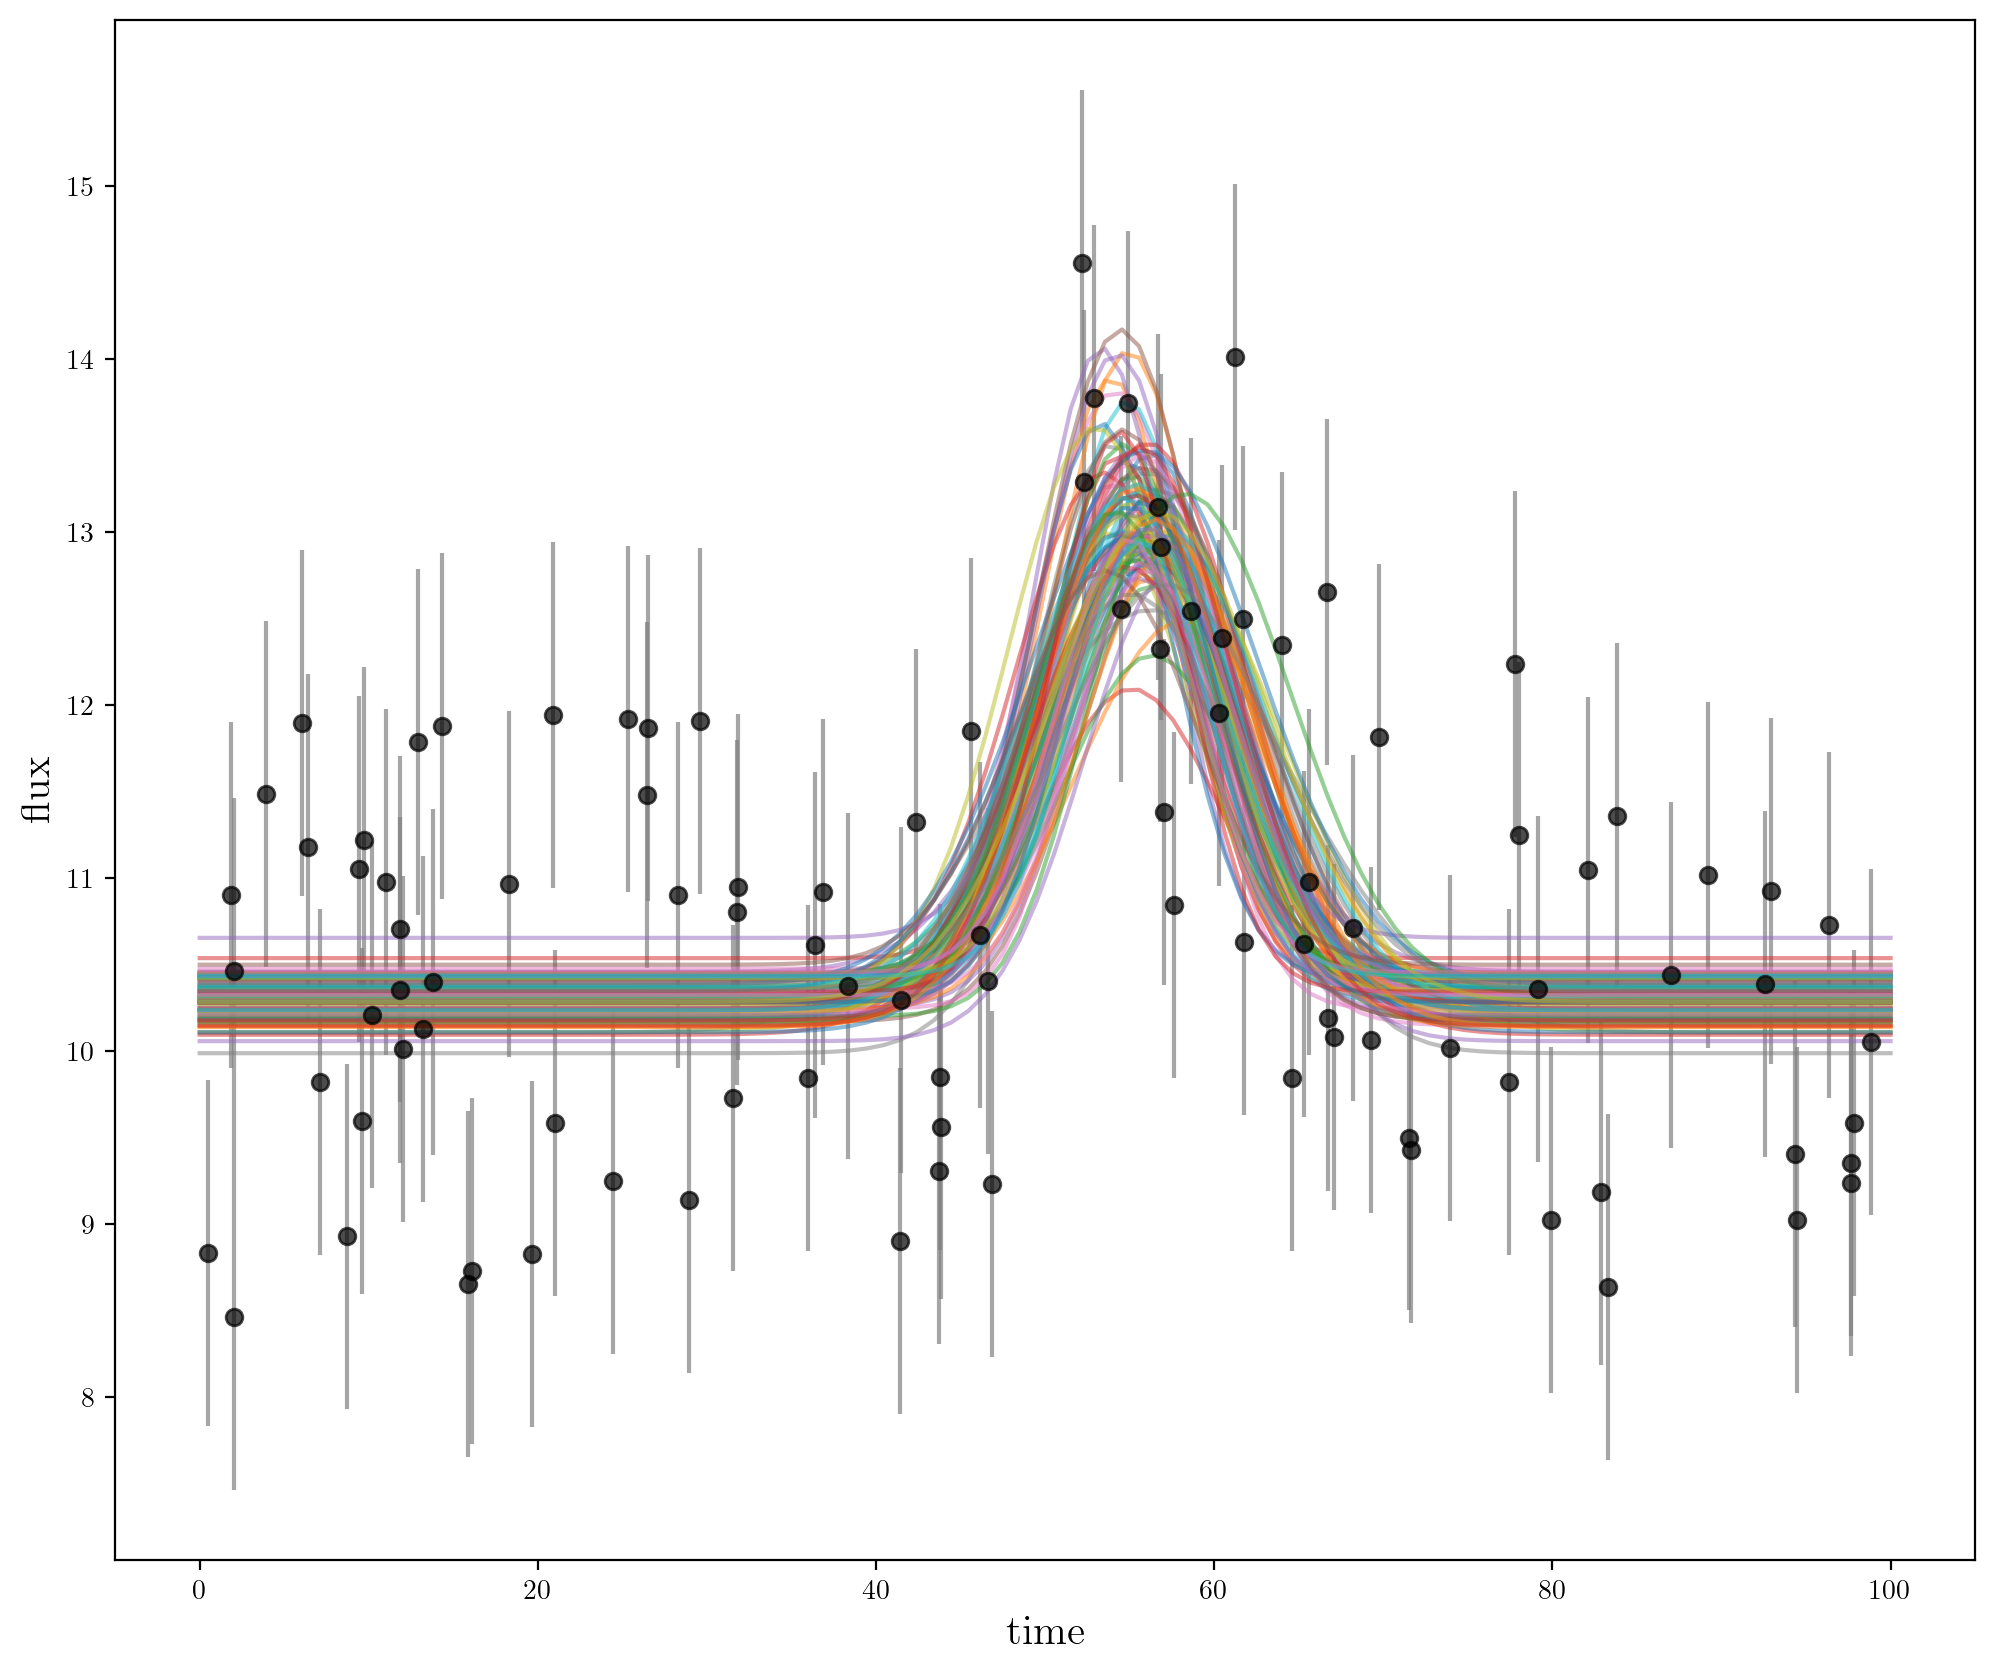

In [239]:
tgrid=np.linspace(0,100,100)

fig = plt.figure(figsize=(12, 10))
plt.errorbar(time, flux, yerr=err_flux, color='black', ecolor='grey', fmt='o', alpha=0.7)

samples = np.random.choice(np.arange(0, len(new_samples_equal)), size=100, replace=False)
chosen_samples= new_samples_equal[samples]

for chosen_theta in chosen_samples:
    t0, b, A, s = chosen_theta
    ygrid =  gaus_burst(tgrid,t0, b, A, s)
    plt.plot(tgrid,ygrid,alpha=0.5)

plt.xlabel('time',fontsize=15)
plt.ylabel('flux',fontsize=15)
plt.show()

## Bayesian Evidence

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

from DYNESTY i got the log of the Evidence

$ev=logE$ and $\sigma_{ev}$ 

so I can compute the evidence like 

$E = e^{ev}$ 

and the error $\sigma_E = \sigma_{ev} \frac{dE}{d(ev)}$

In [59]:
evidence_burst = np.exp(sresults.logz[-1]) #evidence, exp(log of the marginal likeli)
errev_burst = sresults.logzerr[-1] * evidence_burst #with propoag of error rule
print(f"Bayesian evidence of burst model {evidence_burst} ± {errev_burst} ")

evidence_gaus = np.exp(new_sresults.logz[-1]) 
errev_gaus = new_sresults.logzerr[-1] * evidence_gaus
print(f"Bayesian evidence of gaussian model {evidence_gaus} ± {errev_gaus}")

Bayesian evidence of burst model 5.919622598720949e-108 ± 1.75052027888585e-108 
Bayesian evidence of gaussian model 1.3531446271358097e-110 ± 4.24533361619779e-111


Bayes factor 

$B_{21} = \frac{E_1}{E_2}$

$\sigma_{B_{21}} = \sqrt{\frac{\sigma_{E_1}^2}{E_2^2} + \left (-\frac{E_1}{E_2^2} \right)^2 \sigma_{E_2}^2}$ 

In [61]:
B_factor = evidence_burst/evidence_gaus
err_B_factor = np.sqrt( errev_burst**2 / evidence_gaus**2 + evidence_burst**2 * errev_gaus**2 / evidence_gaus**2)

In [63]:
print(f'Since the Bayes factor (burst model over gaussian model) is {B_factor :.2f} ± {err_B_factor:.2f} we can say that the evidence is very strong in favour of the burst model')

Since the Bayes factor (burst model over gaussian model) is 437.47 ± 129.37 we can say that the evidence is very strong in favour of the burst model
